# Compute Mutual Information on MNIST Dataset + PSF Combinations, add varied levels of photon noise, 9/25/2023

## TODO from henry meeting: rerun with bootstrapping, use confidence_interval=0.90
Typical camera has read noise 2.3, peak QA is 65%, so SD 5 photons of gaussian noise. A 5 photon signal isn't reasonable. Start at 20 average signal value, 10 photon bias on all images. Do increments of 20 - 20, 40, 60, 80, 100, 150, 200, 250, 300, 350.
Notebook that makes the plot so you can rerun it.
With the confidence interval in here.


In [4]:
%load_ext autoreload 
%autoreload 2

In [5]:
import numpy as np
from leyla_fns import *
import sys
sys.path.insert(0, '/home/lkabuli_waller/workspace/EncodingInformation/')
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
print(os.environ.get('PYTHONPATH'))
import matplotlib.pyplot as plt

“:/home/lkabuli_waller/workspace/BSCCM:/home/lkabuli_waller/workspace/microscoBayes”


In [6]:
from image_utils import add_shot_noise as add_shot_noise_new
from image_utils import extract_patches
from information_estimation import estimate_mutual_information 

### Load PSFs and MNIST Dataset
Dataset gets converted to units of photons, arbitrarily at maximum of 1000 photons for now

In [7]:
diffuser_psf = load_diffuser_psf()
phlat_psf = load_phlat_psf()
psf_4_psf = load_4_psf()
rml_psf = load_rml_new_psf() # updating to the new rml psf
one_psf = load_single_lens()
two_psf = load_two_lens()
no_psf = np.zeros((28, 28)) # adding a no-PSF convolving case just to have it available
no_psf[14, 14] = 1
no_psf /= np.sum(no_psf)

In [4]:
#load mnist data
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
data = data.astype(np.float32)
for i in range(data.shape[0]):
    data[i] /= np.max(data[i])
    data[i] *= 1000 # convert to photons with arbitrary maximum value of 1000 photons
labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 

# set seed value for reproducibility and tile data using full mnist dataset
seed_value = 1
random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)

In [5]:
# make 5 imaging modality datas using the loaded psfs
og_data = random_data[:, 14:-13, 14:-13]
uc_data = convolved_dataset(no_psf, random_data)
one_data = convolved_dataset(one_psf, random_data)
two_data = convolved_dataset(two_psf, random_data)
psf_4_data = convolved_dataset(psf_4_psf, random_data)
diffuser_data = convolved_dataset(diffuser_psf, random_data)
phlat_data = convolved_dataset(phlat_psf, random_data)
rml_data = convolved_dataset(rml_psf, random_data)

100%|██████████| 70000/70000 [00:31<00:00, 2234.75it/s]


In [6]:
bias = 5

og_data += bias
uc_data += bias
one_data += bias
two_data += bias
psf_4_data += bias
diffuser_data += bias
phlat_data += bias
rml_data += bias

In [7]:
# get rid of super tiny negative values in psf_4 (and other datasets just to be safe)
# this is now obsolete, nothing has negative values since the bias was added
if np.any(uc_data < 0):
    print('UC Data has negatives')
    uc_data[uc_data < 0] = 0
if np.any(one_data < 0):
    print('One Data has negatives')
    one_data[one_data < 0] = 0
if np.any(two_data < 0):
    print("Two Data has negatives")
    two_data[two_data < 0] = 0
if np.any(diffuser_data < 0):
    print('Diffuser Data has negatives')
    diffuser_data[diffuser_data < 0] = 0
if np.any(phlat_data < 0):
    print('Phlat Data has negatives')
    phlat_data[phlat_data < 0] = 0
if np.any(rml_data < 0):
    print('RML Data has negatives')
    rml_data[rml_data < 0] = 0
if np.any(psf_4_data < 0):
    print('PSF_4 Data has negatives')
    psf_4_data[psf_4_data < 0] = 0

### Add noise to each set of images, synthetic shot noise is automatically added based on the existing photon level of the system

In [8]:
og_data_shot = add_shot_noise_new(og_data)
uc_data_shot = add_shot_noise_new(uc_data)
one_data_shot = add_shot_noise_new(one_data)
two_data_shot = add_shot_noise_new(two_data)
psf_4_data_shot = add_shot_noise_new(psf_4_data)
diffuser_data_shot = add_shot_noise_new(diffuser_data)
phlat_data_shot = add_shot_noise_new(phlat_data)
rml_data_shot = add_shot_noise_new(rml_data)

### Extract patches from the stack of images, make noisefree and noisy patches
Using patch size of 28 and 10,000 patches gives super consistent results. 

It is valuable to test the same behavior using a smaller patch size, as well as going up to 60,000 or more patches (the true size of the MNIST dataset).

In [9]:
patch_size = 28
num_patches = 10000

In [10]:
og_data_patch = extract_patches(og_data, patch_size=patch_size, num_patches=num_patches, seed=1)
uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)

100%|██████████| 10000/10000 [00:00<00:00, 801985.51it/s]


In [11]:
og_data_shot_patch = extract_patches(og_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)

100%|██████████| 10000/10000 [00:12<00:00, 807.14it/s]


### Estimate mutual information from the noisy image set combo
Tweak patch size, number of patches, and cutoff until something shows up good

#### Using entire image for the noise free patches
With the code update, this works just fine. Previously it was an issue with dataset size and pixel dimensions, but now it gives consistent results.

In [12]:
cutoff = 5

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


5.149629 5.150072 3.2150126 2.3884592 1.4620962 1.2826748 0.41655493 0.3983121


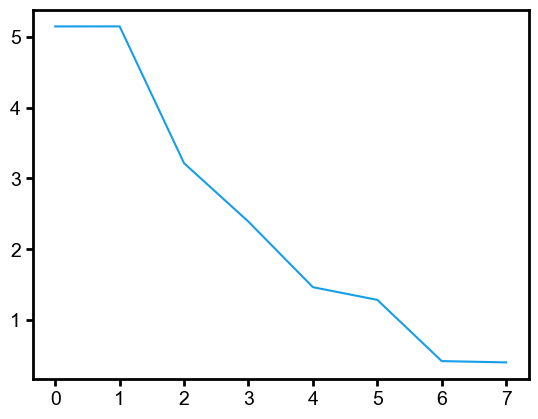

In [13]:
og_mi = estimate_mutual_information(og_data_shot_patch, clean_images=og_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
plt.plot([og_mi, uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi])
print(og_mi, uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)

#### Try using patches for the clean_images set - this works great
As low as cutoff = 5 seems to be just fine. This is with 10,000 data images
Shot noise patches are the main measurement, and clean images are the data patches

In [14]:
cutoff = 5

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

5.1701527 5.169076 3.2397413 2.4064627 1.4740763 1.2789226 0.41612244 0.3995142


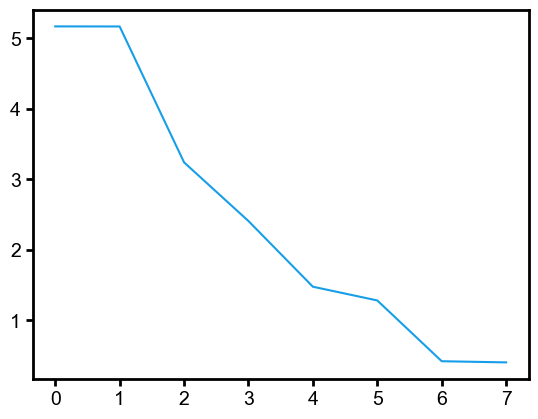

In [15]:
og_mi = estimate_mutual_information(og_data_shot_patch, clean_images=og_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
plt.plot([og_mi, uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi])
print(og_mi, uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)

#### Use the shot noise patches as is, and don't have a clean_image reference
This works great as well, it is super consistent with the true results from above with the patches for clean_images

In [16]:
cutoff = 5

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


5.264271 5.263257 3.3132968 2.4507527 1.4931331 1.2840147 0.4190855 0.40247583


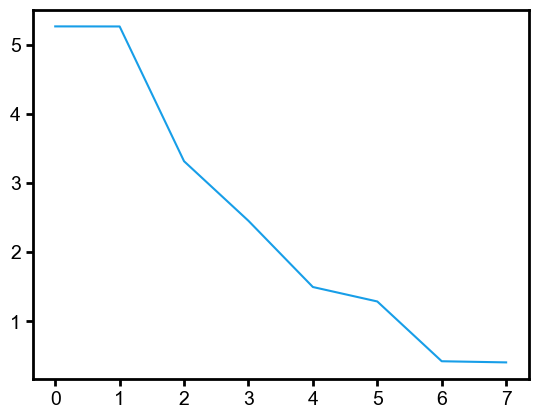

In [17]:
og_mi_nc = estimate_mutual_information(og_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
plt.plot([og_mi_nc, uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc])
print(og_mi_nc, uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc)

#### Compare the clean_image vs no clean_image outputs

In [18]:
print(og_mi_nc, uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc)
print(og_mi_nc, uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)
print(og_mi_nc - og_mi, uc_mi_nc - uc_mi, one_mi_nc - one_mi, two_mi_nc - two_mi, psf_4_mi_nc - psf_4_mi, rml_mi_nc - rml_mi, diffuser_mi_nc - diffuser_mi, phlat_mi_nc - phlat_mi)

5.264271 5.263257 3.3132968 2.4507527 1.4931331 1.2840147 0.4190855 0.40247583
5.264271 5.169076 3.2397413 2.4064627 1.4740763 1.2789226 0.41612244 0.3995142
0.09411812 0.09418106 0.07355547 0.044290066 0.019056797 0.005092144 0.002963066 0.0029616356


Text(0.5, 1.0, 'Mutual Information across Imaging Encoders')

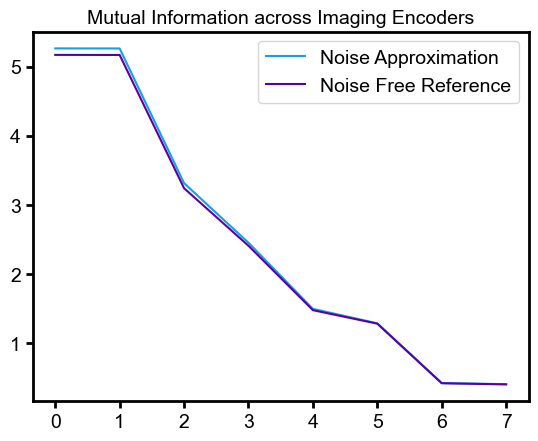

In [19]:
plt.plot([og_mi_nc, uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc], label='Noise Approximation')
plt.plot([og_mi, uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi], label='Noise Free Reference')
plt.legend()
plt.title('Mutual Information across Imaging Encoders')

## Sweep different photon levels - use photon levels of 1, 2, 5, 10, 25, 50, 60, 80, 100 for 1k images
Keeping patch size at 28 is reasonable, now need to change photon levels.

### Load MNIST dataset and check average photon amount
Use average photons going forward. Sweep from 50 to 300 or 500 photons average.
The original data on 0-255 scale has an average pixel value of 33.39. 

In [4]:
# og, uc, one_lens, two_lens, psf_4, rml, diffuser_phlat
mi_using_clean = []
mi_without_clean = []

Loading data and normalizing to mean_photon =  5
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2202.49it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 744.68it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Loading data and normalizing to mean_photon =  10
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2192.26it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 725.16it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Loading data and normalizing to mean_photon =  25
Making the convolved datasets


100%|██████████| 70000/70000 [00:32<00:00, 2183.40it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 734.79it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Loading data and normalizing to mean_photon =  50
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2228.99it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 743.43it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Loading data and normalizing to mean_photon =  60
Making the convolved datasets


100%|██████████| 70000/70000 [00:29<00:00, 2345.30it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 885.98it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Loading data and normalizing to mean_photon =  80
Making the convolved datasets


100%|██████████| 70000/70000 [00:32<00:00, 2179.35it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 729.70it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Matrix not positive definite. Adding 66.17389678955078 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Matrix not positive definite. Adding 66.17389678955078 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Loading data and normalizing to mean_photon =  100
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2221.23it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 712.47it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Matrix not positive definite. Adding 75.80773162841797 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Matrix not positive definite. Adding 75.80773162841797 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Loading data and normalizing to mean_photon =  150
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2245.92it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 744.14it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Matrix not positive definite. Adding 88.39144897460938 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Matrix not positive definite. Adding 88.39144897460938 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Loading data and normalizing to mean_photon =  200
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2249.82it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 755.97it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Matrix not positive definite. Adding 85.52012634277344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Matrix not positive definite. Adding 85.52012634277344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Loading data and normalizing to mean_photon =  250
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2306.85it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 744.55it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Matrix not positive definite. Adding 69.43621063232422 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Matrix not positive definite. Adding 169.71145629882812 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Matrix not positive definite. Adding 69.43621063232422 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
/home/lkabuli_waller/workspace/EncodingInformation/image_utils.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(3, 3))


Matrix not positive definite. Adding 169.71145629882812 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Loading data and normalizing to mean_photon =  300
Making the convolved datasets


100%|██████████| 70000/70000 [00:29<00:00, 2340.98it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 872.16it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Matrix not positive definite. Adding 39.93742370605469 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Matrix not positive definite. Adding 181.68307495117188 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Matrix not positive definite. Adding 39.93742370605469 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Matrix not positive definite. Adding 181.68307495117188 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


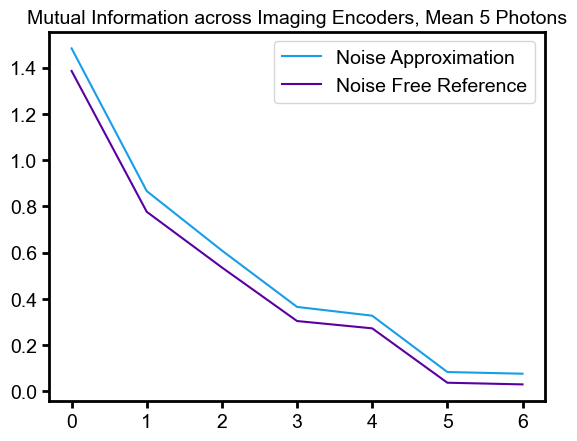

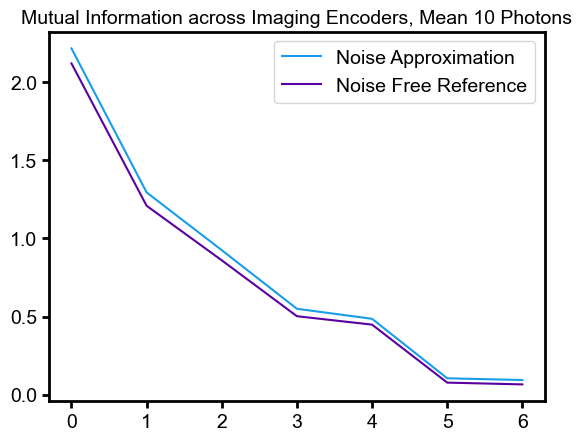

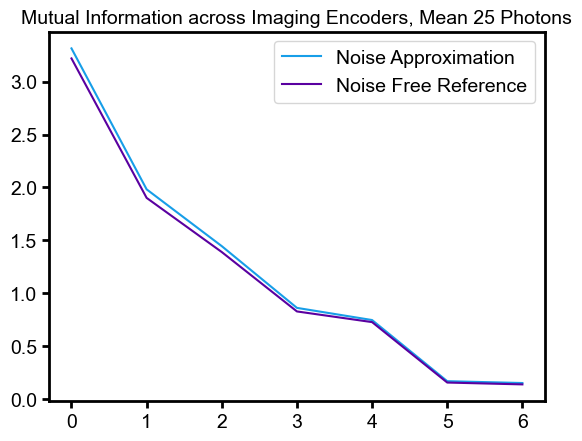

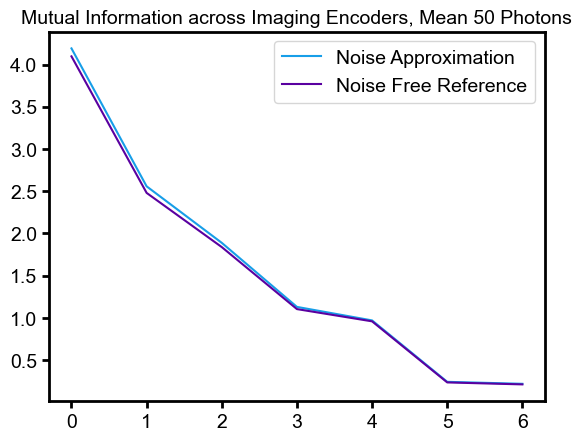

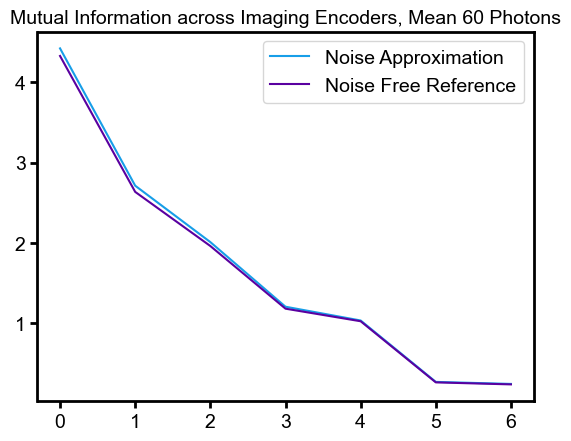

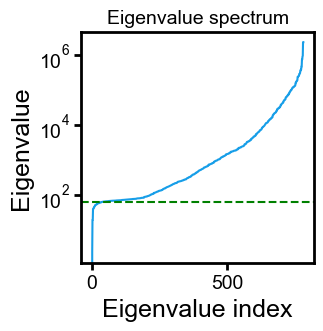

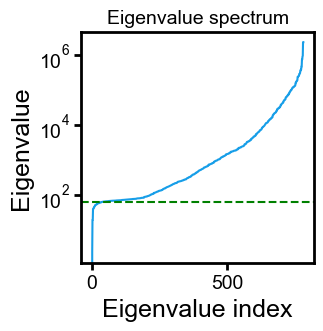

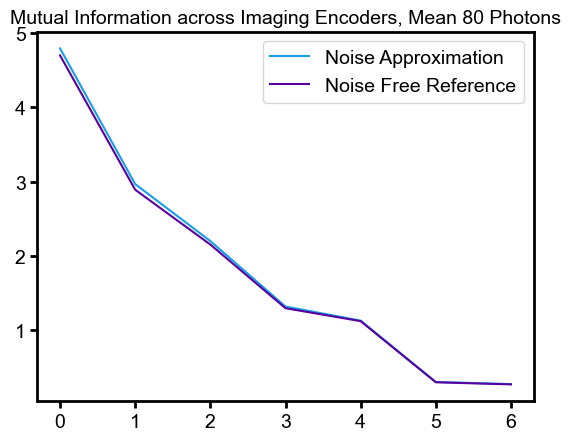

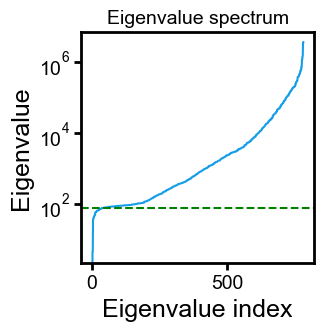

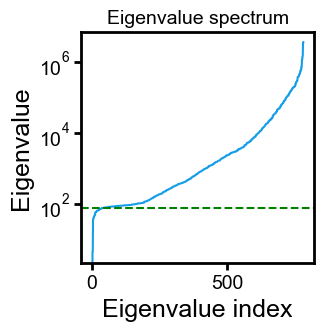

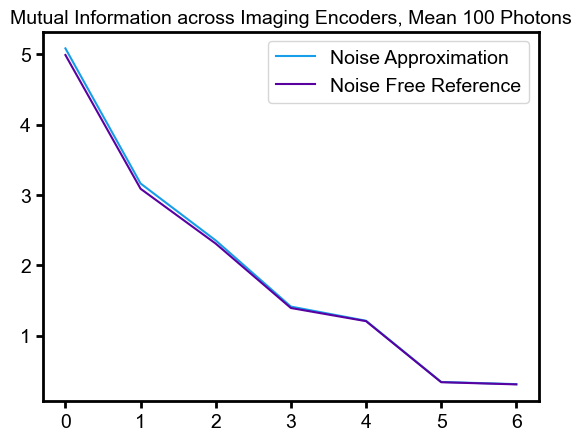

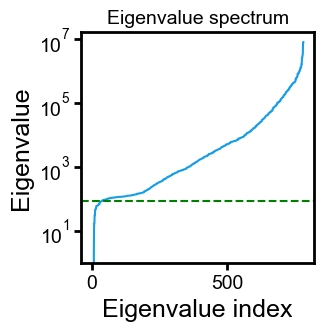

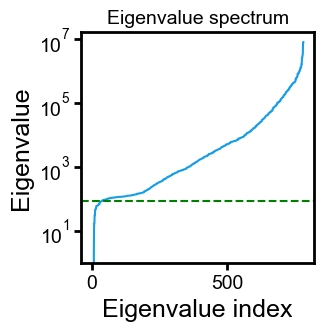

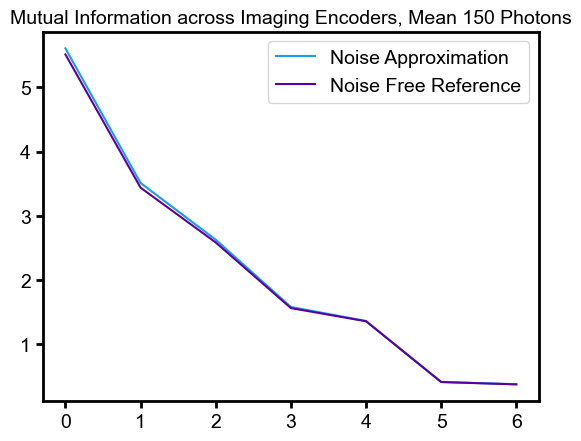

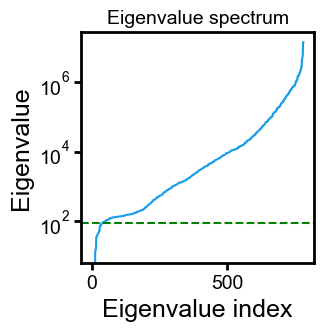

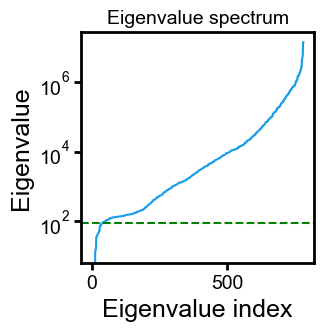

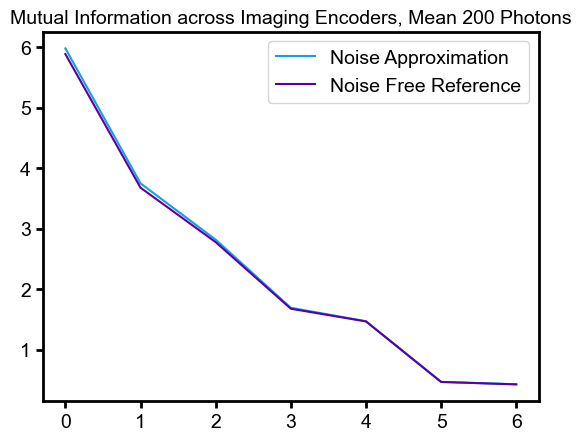

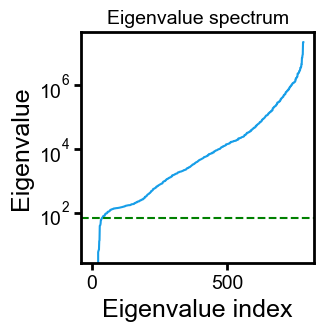

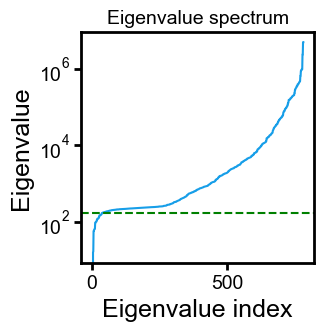

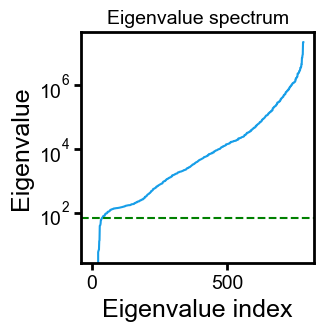

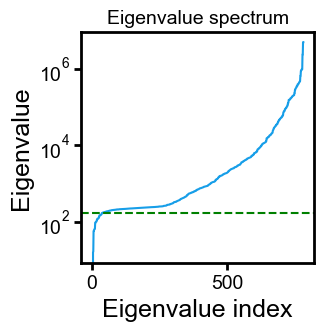

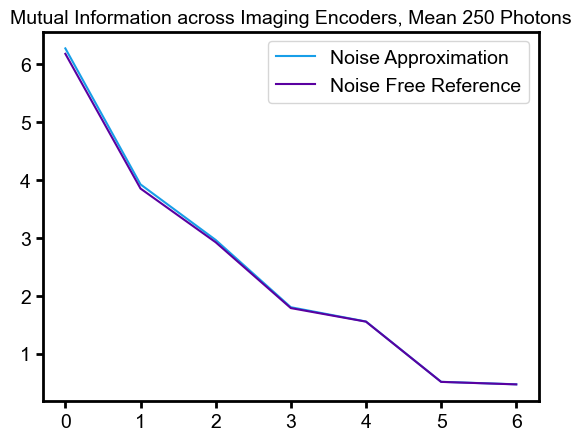

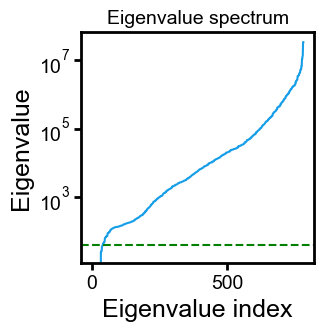

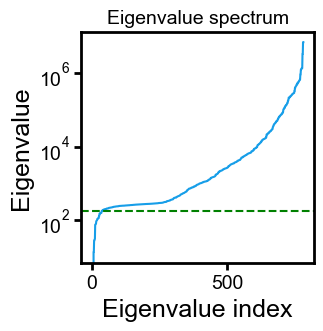

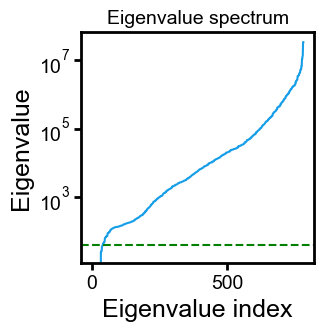

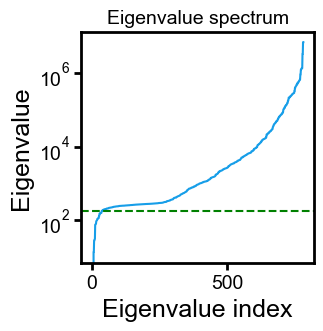

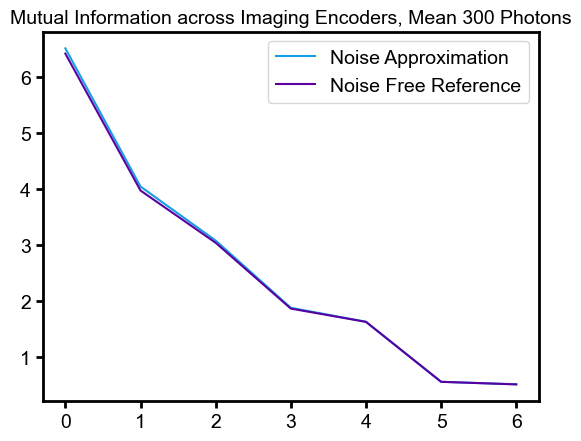

In [5]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]
patch_size = 28
num_patches = 1000
cutoff = 5
bias = 5 # 5 photons
for mean_photon in mean_photons:
    # go through entire process
    #load mnist data
    print('Loading data and normalizing to mean_photon = ', mean_photon)
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
    data = data.astype(np.float32)
    # adjust for mean value
    for i in range(data.shape[0]):
        data[i] /= np.max(data[i]) # max normalize
        data[i] /= np.mean(data[i]) # then mean normalize
        data[i] = data[i] * mean_photon # shift to have mean pixel value of mean_photon
    labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 
    # set seed value for reproducibility and tile data using full mnist dataset
    seed_value = 1
    random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
    # make the 5 datasets 
    print('Making the convolved datasets')
    uc_data = convolved_dataset(no_psf, random_data)
    one_data = convolved_dataset(one_psf, random_data)
    two_data = convolved_dataset(two_psf, random_data)
    psf_4_data = convolved_dataset(psf_4_psf, random_data)
    diffuser_data = convolved_dataset(diffuser_psf, random_data)
    phlat_data = convolved_dataset(phlat_psf, random_data)
    rml_data = convolved_dataset(rml_psf, random_data)
    # add bias to each one rather than getting rid of negative values
    uc_data += bias 
    one_data += bias
    two_data += bias
    psf_4_data += bias
    diffuser_data += bias
    phlat_data += bias
    rml_data += bias
    # add the appropriate amount of shot noise
    print("Adding shot noise to each dataset")
    uc_data_shot = add_shot_noise_new(uc_data)
    one_data_shot = add_shot_noise_new(one_data)
    two_data_shot = add_shot_noise_new(two_data)
    psf_4_data_shot = add_shot_noise_new(psf_4_data)
    diffuser_data_shot = add_shot_noise_new(diffuser_data)
    phlat_data_shot = add_shot_noise_new(phlat_data)
    rml_data_shot = add_shot_noise_new(rml_data)
    print("Extracting patches from each dataset")
    # extract patches with no noise
    uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    # patches with noise
    uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    print("Computing Mutual Information")
    # calculate using clean images
    uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    clean_output = [uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi]
    # calculate without any clean images
    uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    not_clean_output = [uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc]
    plt.figure()
    plt.plot(not_clean_output, label='Noise Approximation')
    plt.plot(clean_output, label='Noise Free Reference')
    plt.legend()
    plt.title('Mutual Information across Imaging Encoders, Mean {} Photons'.format(mean_photon))
    mi_using_clean.append(clean_output)
    mi_without_clean.append(not_clean_output)
                    

In [6]:
np.save('mi_estimates/mi_using_clean_1k_images_bias_5.npy', mi_using_clean)
np.save('mi_estimates/mi_without_clean_1k_images_bias_5.npy', mi_without_clean)

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images, 5 photon bias')

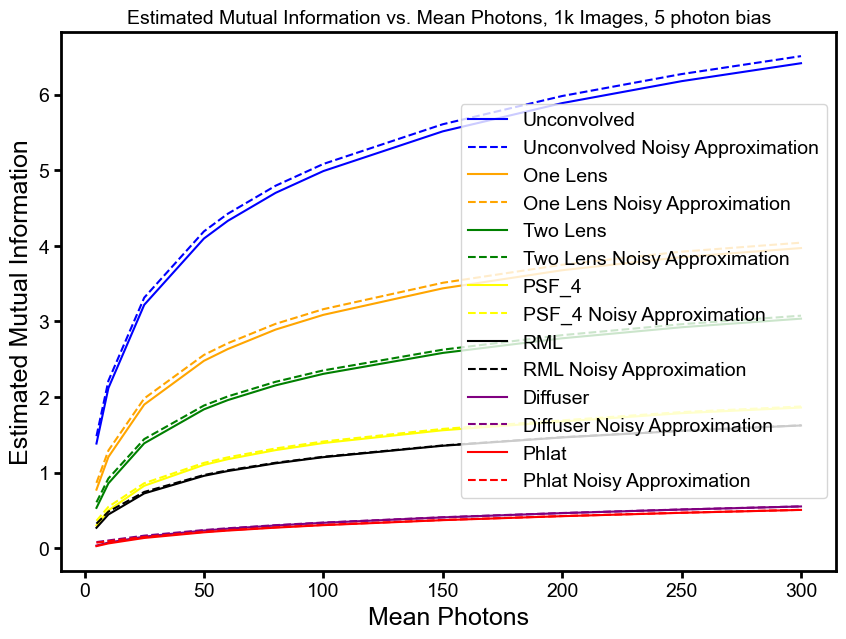

In [7]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_1k_images_bias_5.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_1k_images_bias_5.npy')

plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color='yellow')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color='yellow', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 1k Images, 5 photon bias')

## Sweep photon levels for 10k images

## Sweep different photon levels - use photon levels of 1, 2, 5, 10, 25, 50, 60, 80, 100 for 1k images
Keeping patch size at 28 is reasonable, now need to change photon levels.

### Load MNIST dataset and check average photon amount
Use average photons going forward. Sweep from 50 to 300 or 500 photons average.
The original data on 0-255 scale has an average pixel value of 33.39. 

In [8]:
# og, uc, one_lens, two_lens, psf_4, rml, diffuser_phlat
mi_using_clean = []
mi_without_clean = []

Loading data and normalizing to mean_photon =  5
Making the convolved datasets


100%|██████████| 70000/70000 [00:29<00:00, 2345.72it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:12<00:00, 800.18it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Loading data and normalizing to mean_photon =  10
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2330.64it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:12<00:00, 795.69it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Loading data and normalizing to mean_photon =  25
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2252.38it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 735.50it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Loading data and normalizing to mean_photon =  50
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2326.62it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 731.38it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Loading data and normalizing to mean_photon =  60
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2244.48it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:12<00:00, 833.17it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Loading data and normalizing to mean_photon =  80
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2252.32it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 740.20it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Loading data and normalizing to mean_photon =  100
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2240.40it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 752.66it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Loading data and normalizing to mean_photon =  150
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2320.52it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 719.60it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Loading data and normalizing to mean_photon =  200
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2290.54it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 715.97it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Matrix not positive definite. Adding 86.9610366821289 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Matrix not positive definite. Adding 86.9610366821289 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Loading data and normalizing to mean_photon =  250
Making the convolved datasets


100%|██████████| 70000/70000 [00:29<00:00, 2366.06it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 757.65it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Matrix not positive definite. Adding 71.80319213867188 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Matrix not positive definite. Adding 181.63223266601562 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Matrix not positive definite. Adding 71.80319213867188 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Matrix not positive definite. Adding 181.63223266601562 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Loading data and normalizing to mean_photon =  300
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2264.00it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 10000/10000 [00:13<00:00, 763.70it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Matrix not positive definite. Adding 40.362606048583984 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Matrix not positive definite. Adding 154.08663940429688 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Matrix not positive definite. Adding 198.7560272216797 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Matrix not positive definite. Adding 40.362606048583984 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
/home/lkabuli_waller/workspace/EncodingInformation/image_utils.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(3, 3))


Matrix not positive definite. Adding 154.08663940429688 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Matrix not positive definite. Adding 198.7560272216797 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


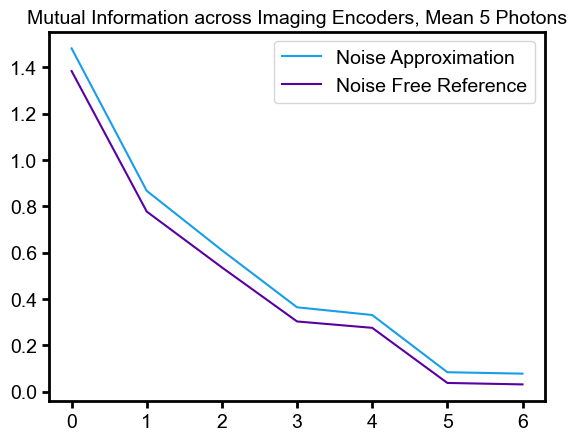

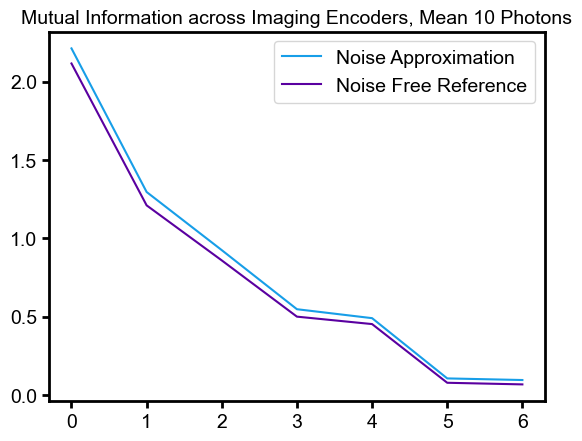

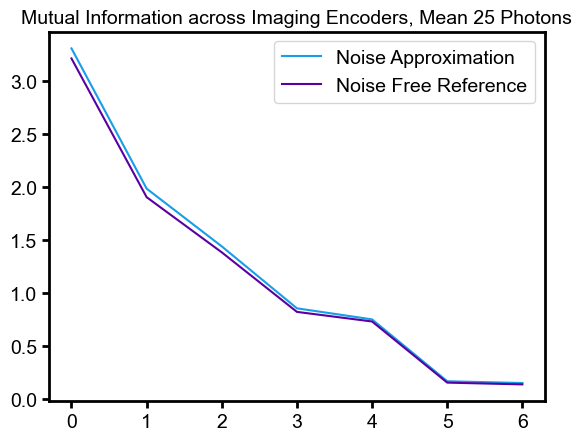

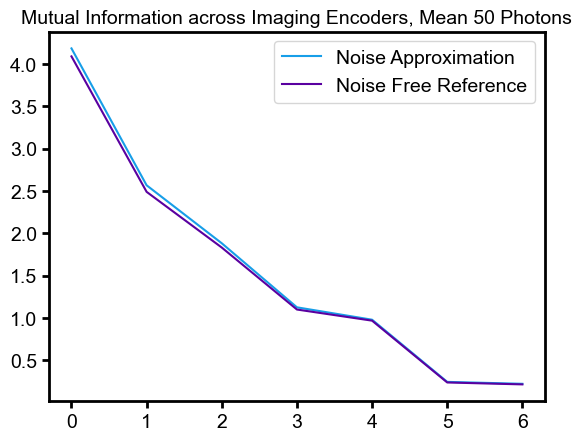

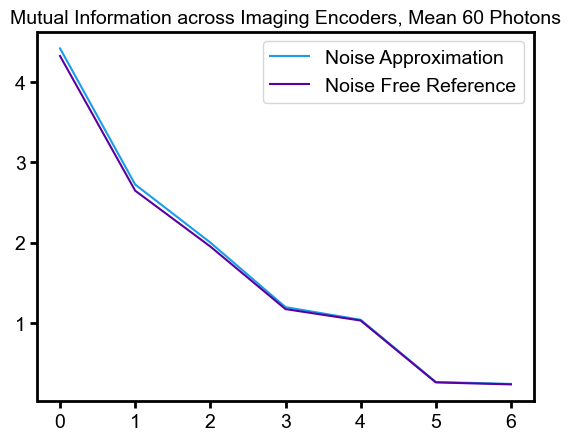

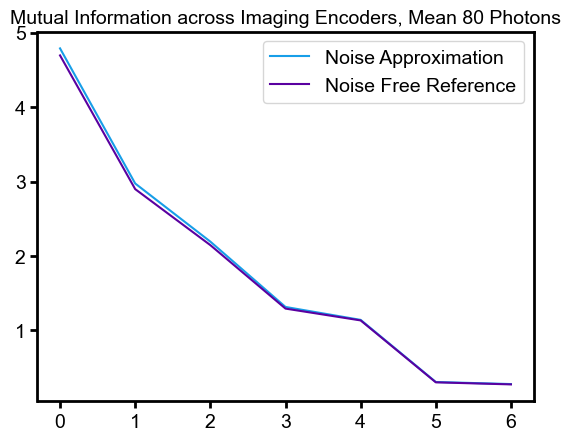

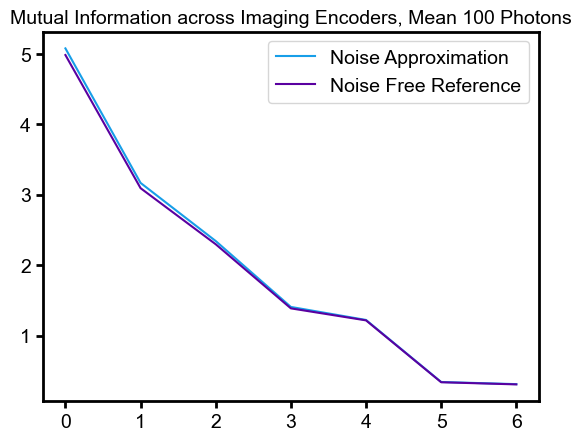

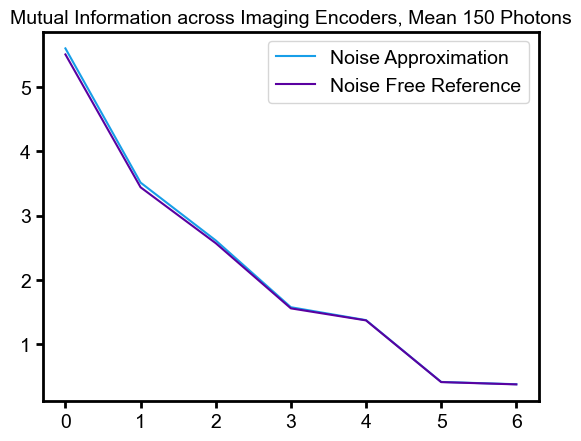

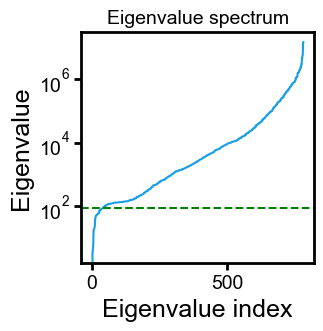

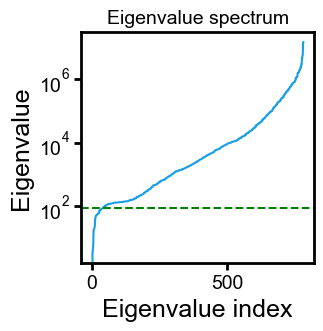

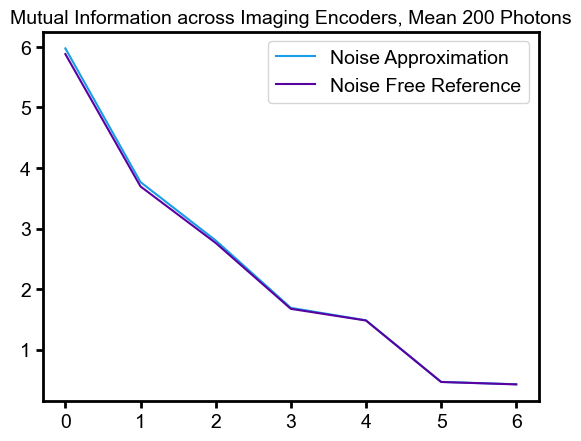

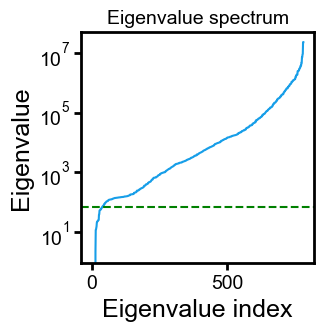

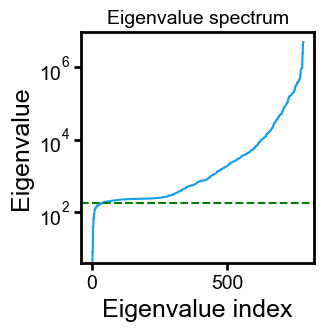

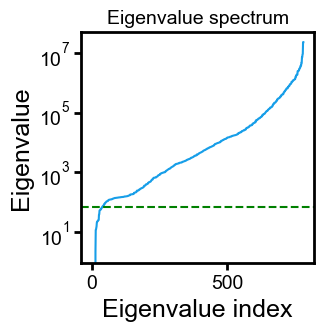

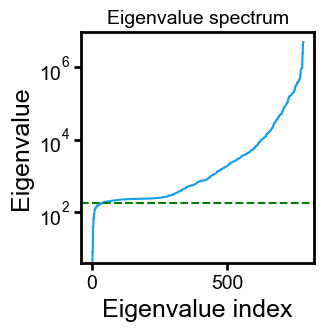

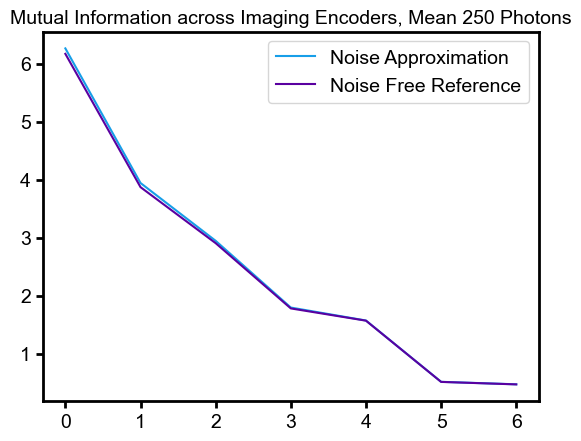

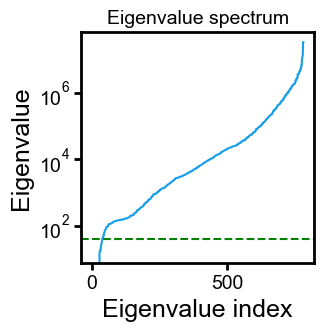

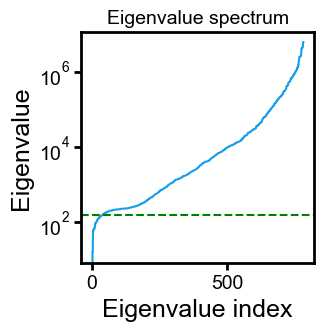

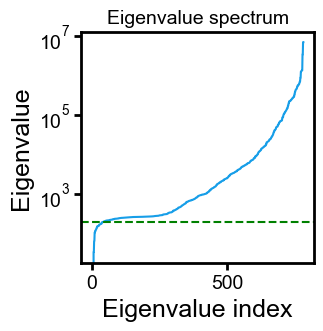

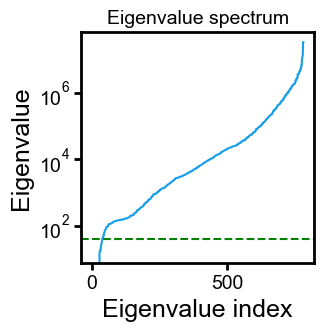

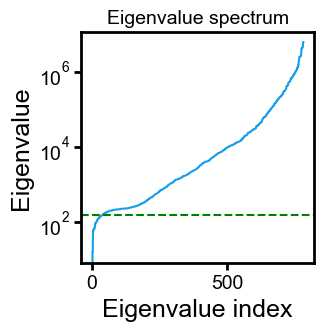

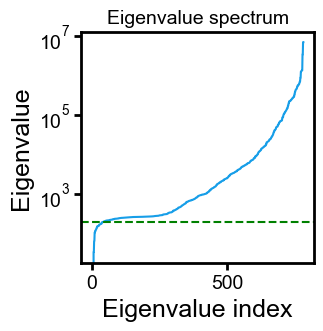

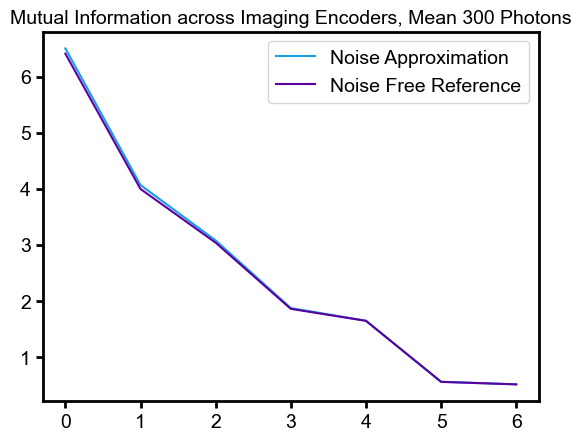

In [9]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]
patch_size = 28
num_patches = 10000
cutoff = 5
bias = 5 # 5 photons
for mean_photon in mean_photons:
    # go through entire process
    #load mnist data
    print('Loading data and normalizing to mean_photon = ', mean_photon)
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
    data = data.astype(np.float32)
    # adjust for mean value
    for i in range(data.shape[0]):
        data[i] /= np.max(data[i]) # max normalize
        data[i] /= np.mean(data[i]) # then mean normalize
        data[i] = data[i] * mean_photon # shift to have mean pixel value of mean_photon
    labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 
    # set seed value for reproducibility and tile data using full mnist dataset
    seed_value = 1
    random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
    # make the 5 datasets 
    print('Making the convolved datasets')
    uc_data = convolved_dataset(no_psf, random_data)
    one_data = convolved_dataset(one_psf, random_data)
    two_data = convolved_dataset(two_psf, random_data)
    psf_4_data = convolved_dataset(psf_4_psf, random_data)
    diffuser_data = convolved_dataset(diffuser_psf, random_data)
    phlat_data = convolved_dataset(phlat_psf, random_data)
    rml_data = convolved_dataset(rml_psf, random_data)
    # add bias to each one rather than getting rid of negative values
    uc_data += bias 
    one_data += bias
    two_data += bias
    psf_4_data += bias
    diffuser_data += bias
    phlat_data += bias
    rml_data += bias
    # add the appropriate amount of shot noise
    print("Adding shot noise to each dataset")
    uc_data_shot = add_shot_noise_new(uc_data)
    one_data_shot = add_shot_noise_new(one_data)
    two_data_shot = add_shot_noise_new(two_data)
    psf_4_data_shot = add_shot_noise_new(psf_4_data)
    diffuser_data_shot = add_shot_noise_new(diffuser_data)
    phlat_data_shot = add_shot_noise_new(phlat_data)
    rml_data_shot = add_shot_noise_new(rml_data)
    print("Extracting patches from each dataset")
    # extract patches with no noise
    uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    # patches with noise
    uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    print("Computing Mutual Information")
    # calculate using clean images
    uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    clean_output = [uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi]
    # calculate without any clean images
    uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    not_clean_output = [uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc]
    plt.figure()
    plt.plot(not_clean_output, label='Noise Approximation')
    plt.plot(clean_output, label='Noise Free Reference')
    plt.legend()
    plt.title('Mutual Information across Imaging Encoders, Mean {} Photons'.format(mean_photon))
    mi_using_clean.append(clean_output)
    mi_without_clean.append(not_clean_output)
                    

In [10]:
np.save('mi_estimates/mi_using_clean_10k_images_bias_5.npy', mi_using_clean)
np.save('mi_estimates/mi_without_clean_10k_images_bias_5.npy', mi_without_clean)

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 10k Images, 5 photon bias')

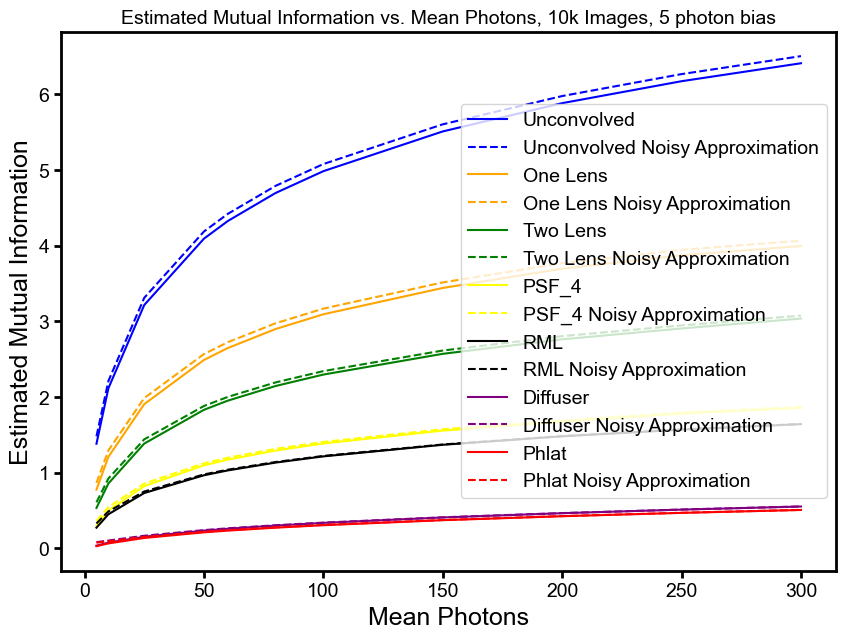

In [11]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_10k_images_bias_5.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_10k_images_bias_5.npy')

plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color='yellow')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color='yellow', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 10k Images, 5 photon bias')

## Sweep different photon levels - use photon levels of 1, 2, 5, 10, 25, 50, 60, 80, 100 for 1k images, 10 photon bias
Keeping patch size at 28 is reasonable, now need to change photon levels.

### Load MNIST dataset and check average photon amount
Use average photons going forward. Sweep from 50 to 300 or 500 photons average.
The original data on 0-255 scale has an average pixel value of 33.39. 

In [13]:
# og, uc, one_lens, two_lens, psf_4, rml, diffuser_phlat
mi_using_clean = []
mi_without_clean = []

Loading data and normalizing to mean_photon =  5
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2305.76it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 801.47it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Loading data and normalizing to mean_photon =  10
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2264.61it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 719.06it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Loading data and normalizing to mean_photon =  25
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2234.97it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 739.07it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Loading data and normalizing to mean_photon =  50
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2253.60it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 714.44it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Loading data and normalizing to mean_photon =  60
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2212.44it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 705.55it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loading data and normalizing to mean_photon =  80
Making the convolved datasets


100%|██████████| 70000/70000 [00:28<00:00, 2445.50it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 729.37it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Matrix not positive definite. Adding 70.72471618652344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Matrix not positive definite. Adding 70.72471618652344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loading data and normalizing to mean_photon =  100
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2305.04it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 868.65it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Matrix not positive definite. Adding 80.89249420166016 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Matrix not positive definite. Adding 80.89249420166016 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Loading data and normalizing to mean_photon =  150
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2235.92it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 749.46it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Matrix not positive definite. Adding 95.54186248779297 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Matrix not positive definite. Adding 95.54186248779297 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Loading data and normalizing to mean_photon =  200
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2217.50it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 862.84it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Matrix not positive definite. Adding 91.05479431152344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Matrix not positive definite. Adding 91.05479431152344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Loading data and normalizing to mean_photon =  250
Making the convolved datasets


100%|██████████| 70000/70000 [00:29<00:00, 2352.27it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 723.85it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Matrix not positive definite. Adding 74.9854965209961 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Matrix not positive definite. Adding 173.7259521484375 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Matrix not positive definite. Adding 74.9854965209961 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Matrix not positive definite. Adding 173.7259521484375 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Loading data and normalizing to mean_photon =  300
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2259.26it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 739.73it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Matrix not positive definite. Adding 44.5084228515625 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Matrix not positive definite. Adding 185.95541381835938 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Matrix not positive definite. Adding 44.5084228515625 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Matrix not positive definite. Adding 185.95541381835938 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


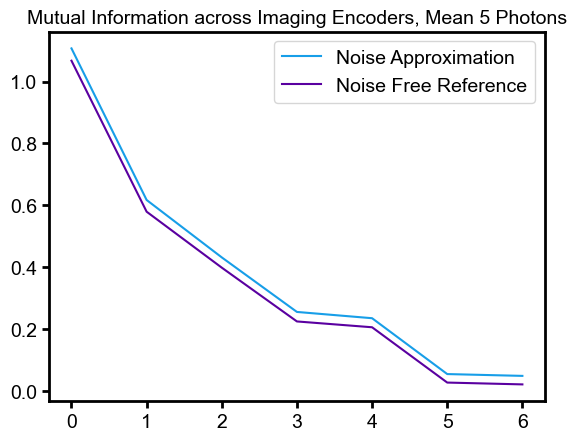

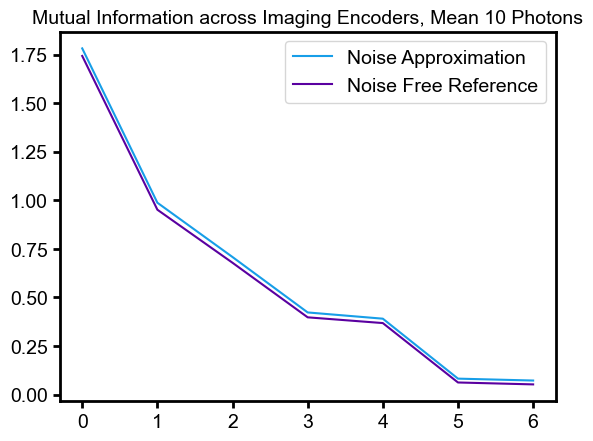

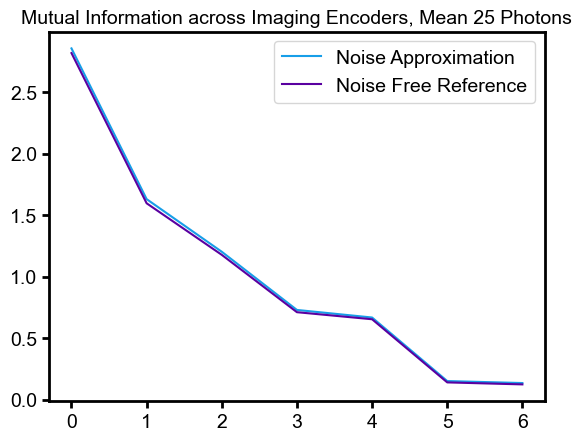

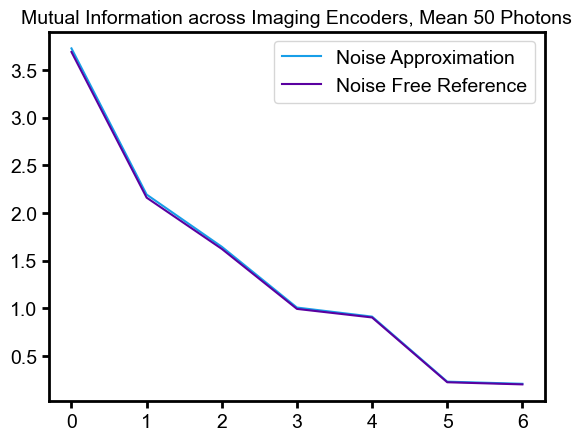

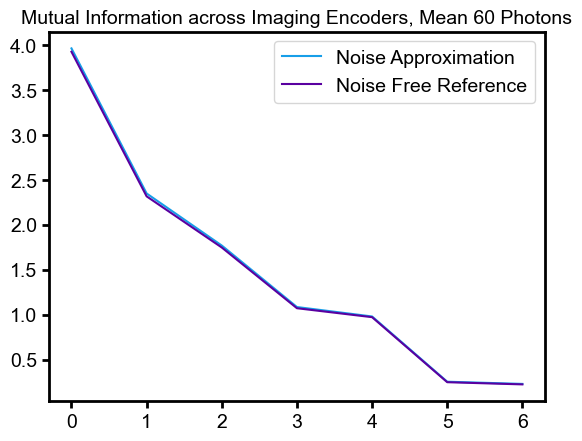

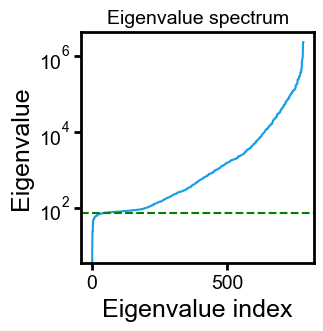

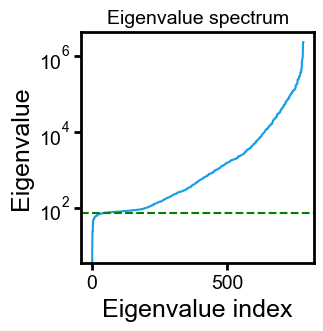

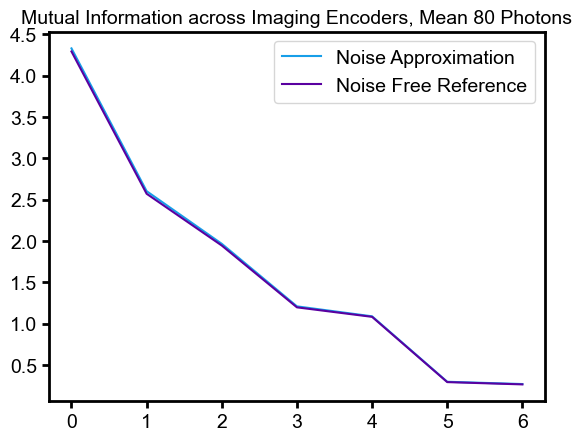

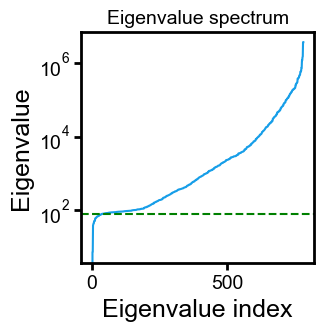

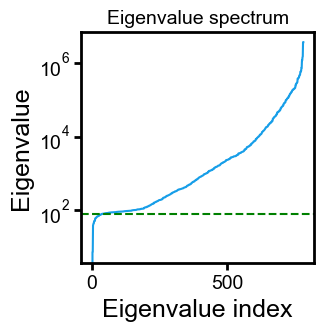

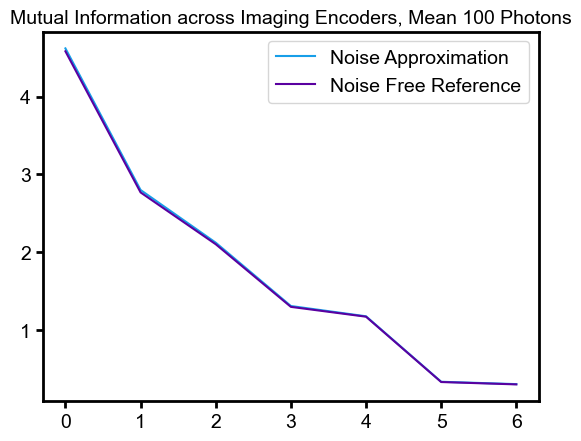

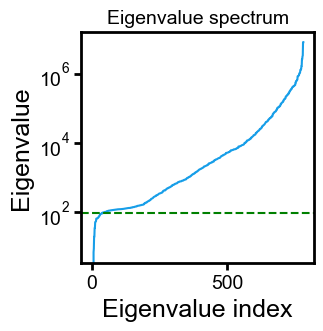

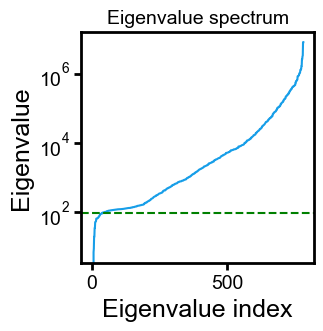

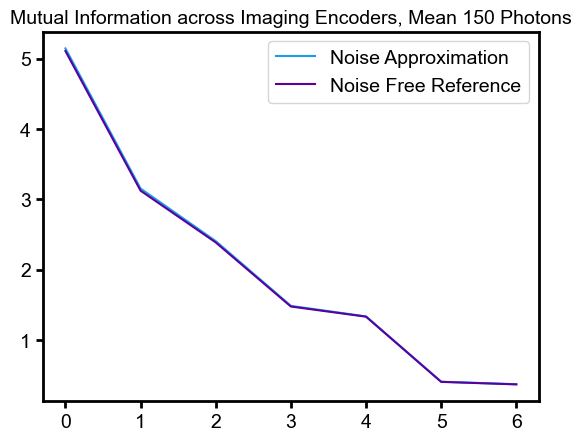

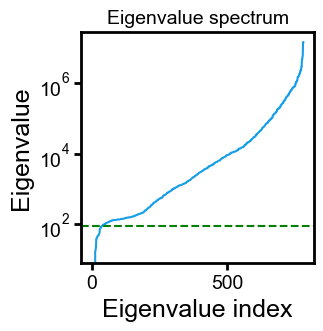

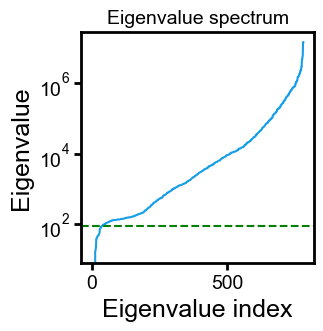

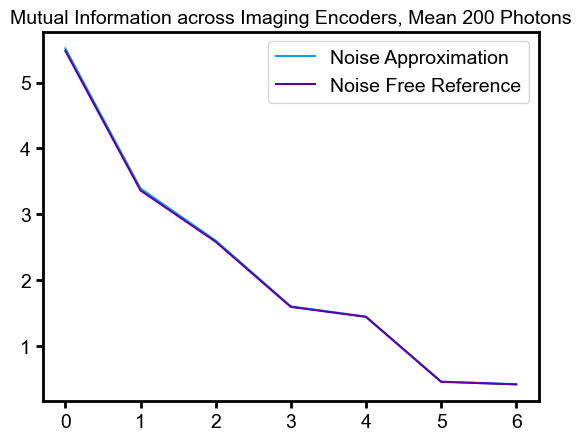

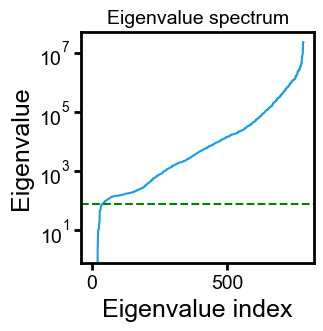

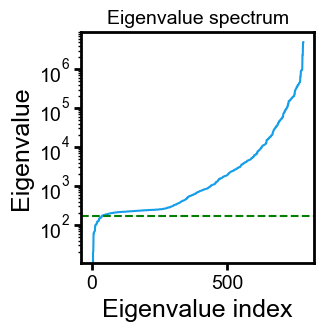

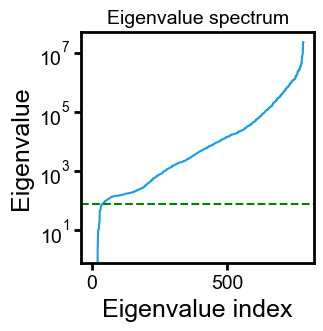

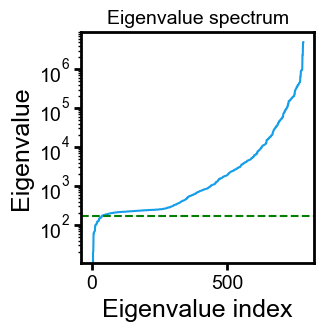

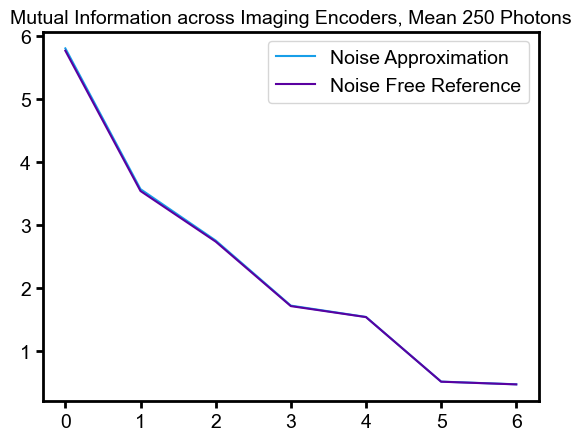

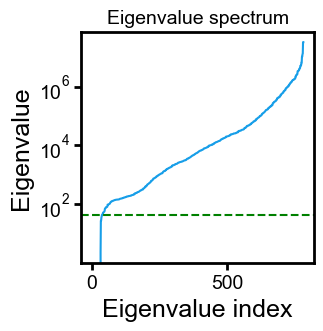

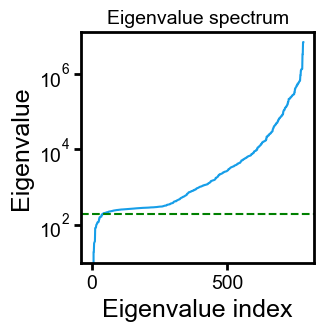

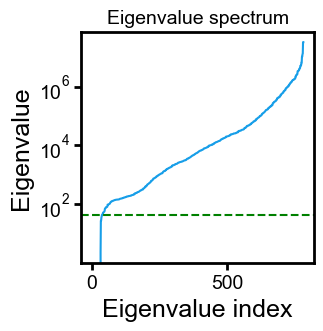

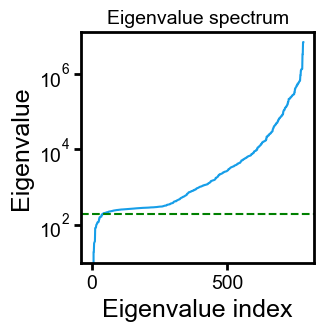

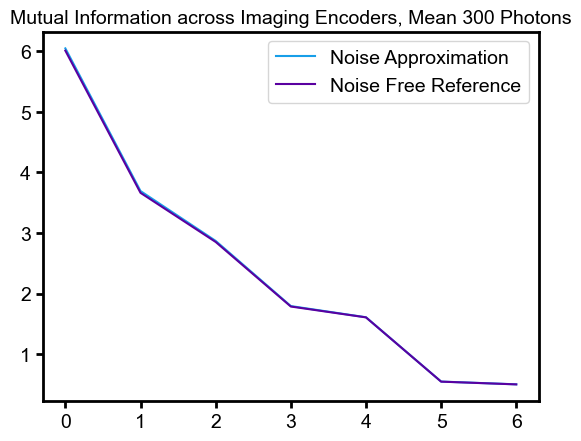

In [14]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]
patch_size = 28
num_patches = 1000
cutoff = 5
bias = 10 # 5 photons
for mean_photon in mean_photons:
    # go through entire process
    #load mnist data
    print('Loading data and normalizing to mean_photon = ', mean_photon)
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
    data = data.astype(np.float32)
    # adjust for mean value
    for i in range(data.shape[0]):
        data[i] /= np.max(data[i]) # max normalize
        data[i] /= np.mean(data[i]) # then mean normalize
        data[i] = data[i] * mean_photon # shift to have mean pixel value of mean_photon
    labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 
    # set seed value for reproducibility and tile data using full mnist dataset
    seed_value = 1
    random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
    # make the 5 datasets 
    print('Making the convolved datasets')
    uc_data = convolved_dataset(no_psf, random_data)
    one_data = convolved_dataset(one_psf, random_data)
    two_data = convolved_dataset(two_psf, random_data)
    psf_4_data = convolved_dataset(psf_4_psf, random_data)
    diffuser_data = convolved_dataset(diffuser_psf, random_data)
    phlat_data = convolved_dataset(phlat_psf, random_data)
    rml_data = convolved_dataset(rml_psf, random_data)
    # add bias to each one rather than getting rid of negative values
    uc_data += bias 
    one_data += bias
    two_data += bias
    psf_4_data += bias
    diffuser_data += bias
    phlat_data += bias
    rml_data += bias
    # add the appropriate amount of shot noise
    print("Adding shot noise to each dataset")
    uc_data_shot = add_shot_noise_new(uc_data)
    one_data_shot = add_shot_noise_new(one_data)
    two_data_shot = add_shot_noise_new(two_data)
    psf_4_data_shot = add_shot_noise_new(psf_4_data)
    diffuser_data_shot = add_shot_noise_new(diffuser_data)
    phlat_data_shot = add_shot_noise_new(phlat_data)
    rml_data_shot = add_shot_noise_new(rml_data)
    print("Extracting patches from each dataset")
    # extract patches with no noise
    uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    # patches with noise
    uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    print("Computing Mutual Information")
    # calculate using clean images
    uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    clean_output = [uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi]
    # calculate without any clean images
    uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    not_clean_output = [uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc]
    plt.figure()
    plt.plot(not_clean_output, label='Noise Approximation')
    plt.plot(clean_output, label='Noise Free Reference')
    plt.legend()
    plt.title('Mutual Information across Imaging Encoders, Mean {} Photons'.format(mean_photon))
    mi_using_clean.append(clean_output)
    mi_without_clean.append(not_clean_output)
                    

In [15]:
np.save('mi_estimates/mi_using_clean_1k_images_bias_10.npy', mi_using_clean)
np.save('mi_estimates/mi_without_clean_1k_images_bias_10.npy', mi_without_clean)

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images, 10 photon bias')

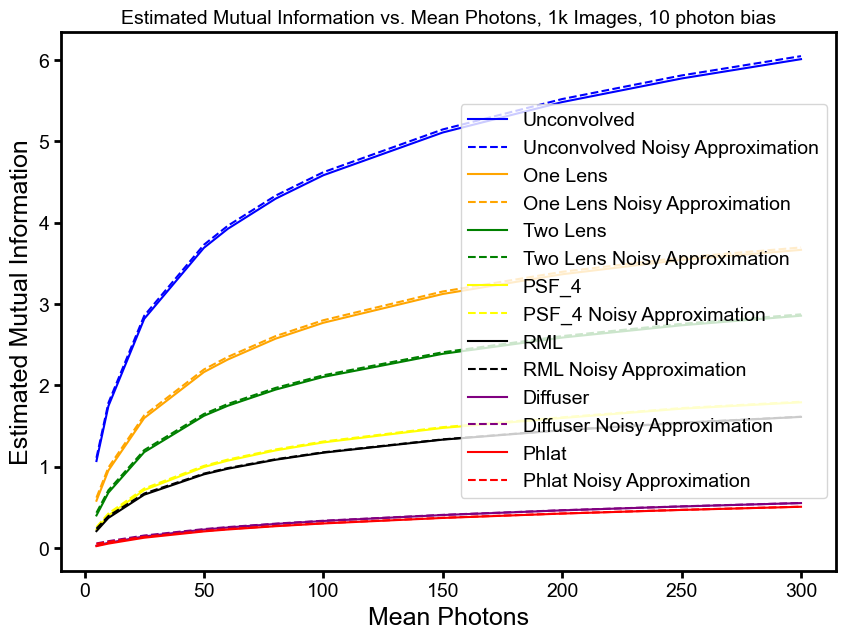

In [16]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_1k_images_bias_10.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_1k_images_bias_10.npy')

plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color='yellow')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color='yellow', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 1k Images, 10 photon bias')

## Sweep different photon levels - use photon levels of 1, 2, 5, 10, 25, 50, 60, 80, 100 for 10k images, 10 photon bias
Keeping patch size at 28 is reasonable, now need to change photon levels.

### Load MNIST dataset and check average photon amount
Use average photons going forward. Sweep from 50 to 300 or 500 photons average.
The original data on 0-255 scale has an average pixel value of 33.39. 

In [6]:
# og, uc, one_lens, two_lens, psf_4, rml, diffuser_phlat
mi_using_clean = []
mi_without_clean = []

In [7]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]
patch_size = 28
num_patches = 10000
cutoff = 5
bias = 10 # 5 photons
for mean_photon in mean_photons:
    # go through entire process
    #load mnist data
    print('Loading data and normalizing to mean_photon = ', mean_photon)
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
    data = data.astype(np.float32)
    # adjust for mean value
    for i in range(data.shape[0]):
        data[i] /= np.max(data[i]) # max normalize
        data[i] /= np.mean(data[i]) # then mean normalize
        data[i] = data[i] * mean_photon # shift to have mean pixel value of mean_photon
    labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 
    # set seed value for reproducibility and tile data using full mnist dataset
    seed_value = 1
    random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
    # make the 5 datasets 
    print('Making the convolved datasets')
    uc_data = convolved_dataset(no_psf, random_data)
    one_data = convolved_dataset(one_psf, random_data)
    two_data = convolved_dataset(two_psf, random_data)
    psf_4_data = convolved_dataset(psf_4_psf, random_data)
    diffuser_data = convolved_dataset(diffuser_psf, random_data)
    phlat_data = convolved_dataset(phlat_psf, random_data)
    rml_data = convolved_dataset(rml_psf, random_data)
    # add bias to each one rather than getting rid of negative values
    uc_data += bias 
    one_data += bias
    two_data += bias
    psf_4_data += bias
    diffuser_data += bias
    phlat_data += bias
    rml_data += bias
    # add the appropriate amount of shot noise
    print("Adding shot noise to each dataset")
    uc_data_shot = add_shot_noise_new(uc_data)
    one_data_shot = add_shot_noise_new(one_data)
    two_data_shot = add_shot_noise_new(two_data)
    psf_4_data_shot = add_shot_noise_new(psf_4_data)
    diffuser_data_shot = add_shot_noise_new(diffuser_data)
    phlat_data_shot = add_shot_noise_new(phlat_data)
    rml_data_shot = add_shot_noise_new(rml_data)
    print("Extracting patches from each dataset")
    # extract patches with no noise
    uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    # patches with noise
    uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    print("Computing Mutual Information")
    # calculate using clean images
    uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    clean_output = [uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi]
    # calculate without any clean images
    uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    not_clean_output = [uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc]
    plt.figure()
    plt.plot(not_clean_output, label='Noise Approximation')
    plt.plot(clean_output, label='Noise Free Reference')
    plt.legend()
    plt.title('Mutual Information across Imaging Encoders, Mean {} Photons'.format(mean_photon))
    mi_using_clean.append(clean_output)
    mi_without_clean.append(not_clean_output)
                    

Loading data and normalizing to mean_photon =  5


Making the convolved datasets


 82%|████████▏ | 57060/70000 [00:25<00:05, 2240.72it/s]

In [ ]:
np.save('mi_estimates/mi_using_clean_10k_images_bias_10.npy', mi_using_clean)
np.save('mi_estimates/mi_without_clean_10k_images_bias_10.npy', mi_without_clean)

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images, 5 photon bias')

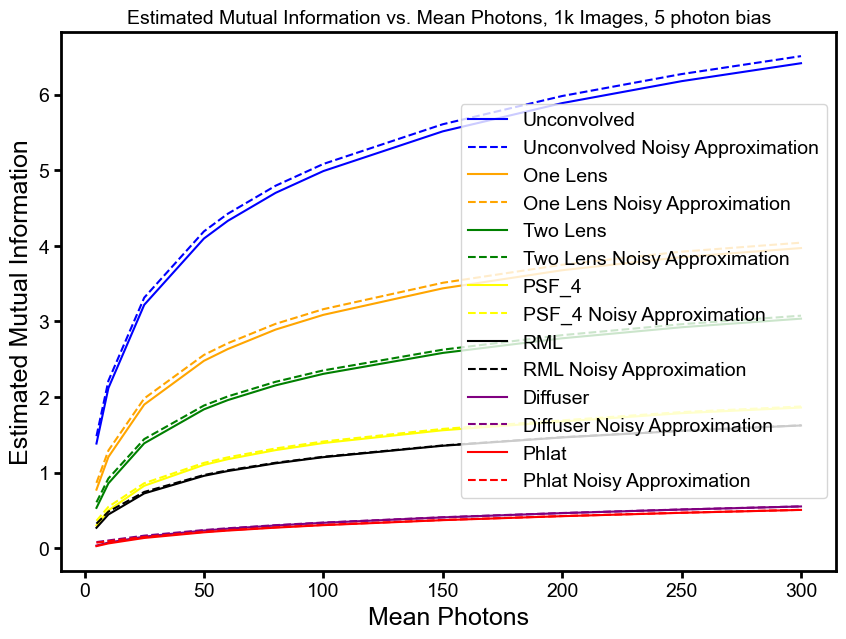

In [ ]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_10k_images_bias_10.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_10k_images_bias_10.npy')

plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color='yellow')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color='yellow', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 10k Images, 10 photon bias')

## Sweep different photon levels - use photon levels of 1, 2, 5, 10, 25, 50, 60, 80, 100 for 1k images, 20 photon bias
Keeping patch size at 28 is reasonable, now need to change photon levels.

### Load MNIST dataset and check average photon amount
Use average photons going forward. Sweep from 50 to 300 or 500 photons average.
The original data on 0-255 scale has an average pixel value of 33.39. 

In [ ]:
# og, uc, one_lens, two_lens, psf_4, rml, diffuser_phlat
mi_using_clean = []
mi_without_clean = []

Loading data and normalizing to mean_photon =  5
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2305.76it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 801.47it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Loading data and normalizing to mean_photon =  10
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2264.61it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 719.06it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Loading data and normalizing to mean_photon =  25
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2234.97it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 739.07it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Loading data and normalizing to mean_photon =  50
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2253.60it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 714.44it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Loading data and normalizing to mean_photon =  60
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2212.44it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 705.55it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loading data and normalizing to mean_photon =  80
Making the convolved datasets


100%|██████████| 70000/70000 [00:28<00:00, 2445.50it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 729.37it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Matrix not positive definite. Adding 70.72471618652344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Matrix not positive definite. Adding 70.72471618652344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loading data and normalizing to mean_photon =  100
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2305.04it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 868.65it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Matrix not positive definite. Adding 80.89249420166016 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Matrix not positive definite. Adding 80.89249420166016 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Loading data and normalizing to mean_photon =  150
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2235.92it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 749.46it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Matrix not positive definite. Adding 95.54186248779297 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Matrix not positive definite. Adding 95.54186248779297 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Loading data and normalizing to mean_photon =  200
Making the convolved datasets


100%|██████████| 70000/70000 [00:31<00:00, 2217.50it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 862.84it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Matrix not positive definite. Adding 91.05479431152344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Matrix not positive definite. Adding 91.05479431152344 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Loading data and normalizing to mean_photon =  250
Making the convolved datasets


100%|██████████| 70000/70000 [00:29<00:00, 2352.27it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 723.85it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Matrix not positive definite. Adding 74.9854965209961 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Matrix not positive definite. Adding 173.7259521484375 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Matrix not positive definite. Adding 74.9854965209961 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Matrix not positive definite. Adding 173.7259521484375 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Loading data and normalizing to mean_photon =  300
Making the convolved datasets


100%|██████████| 70000/70000 [00:30<00:00, 2259.26it/s]


Adding shot noise to each dataset
Extracting patches from each dataset


100%|██████████| 1000/1000 [00:01<00:00, 739.73it/s]


Computing Mutual Information


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Matrix not positive definite. Adding 44.5084228515625 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Matrix not positive definite. Adding 185.95541381835938 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Matrix not positive definite. Adding 44.5084228515625 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Matrix not positive definite. Adding 185.95541381835938 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


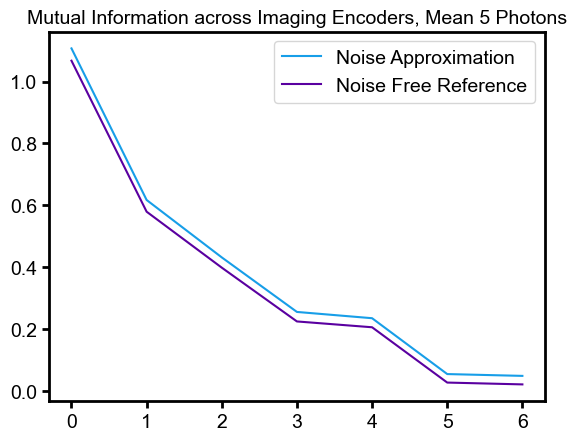

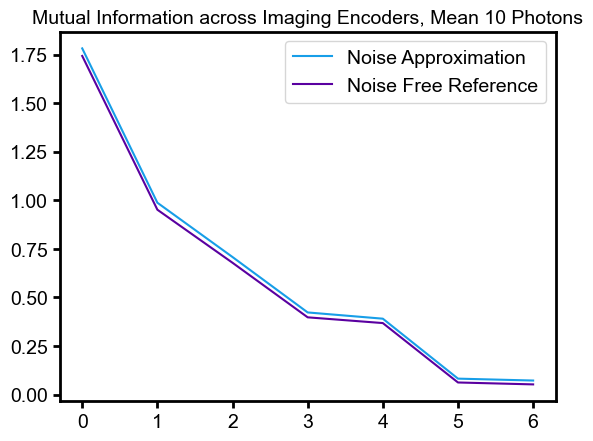

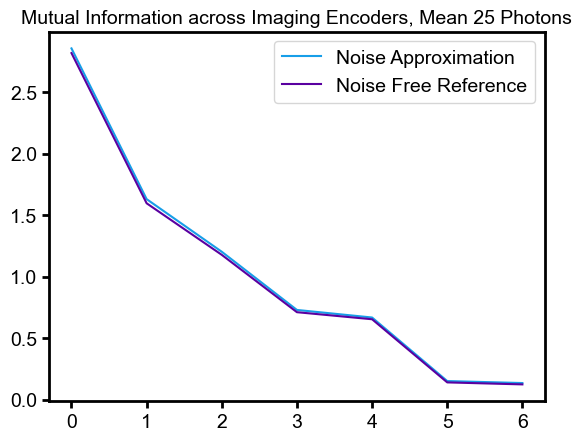

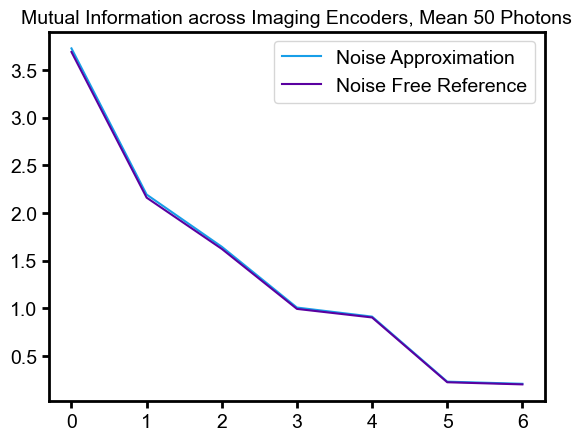

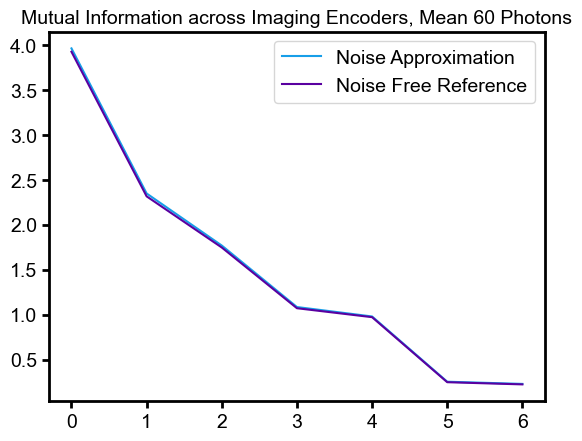

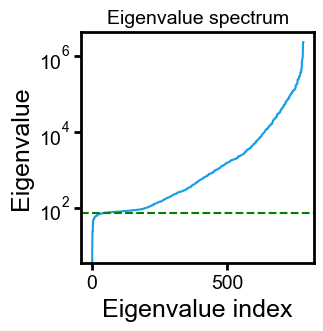

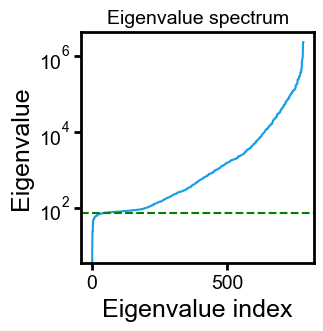

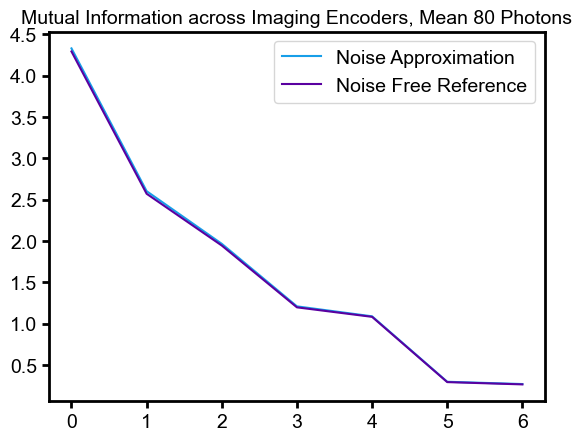

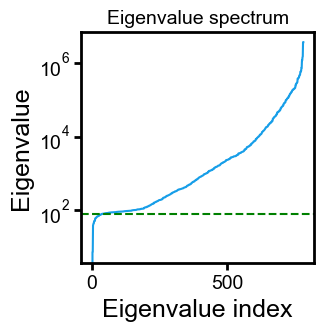

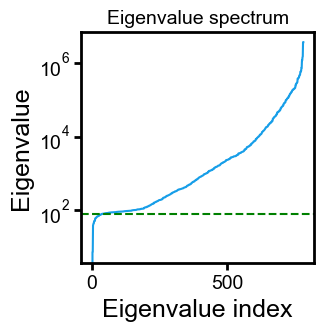

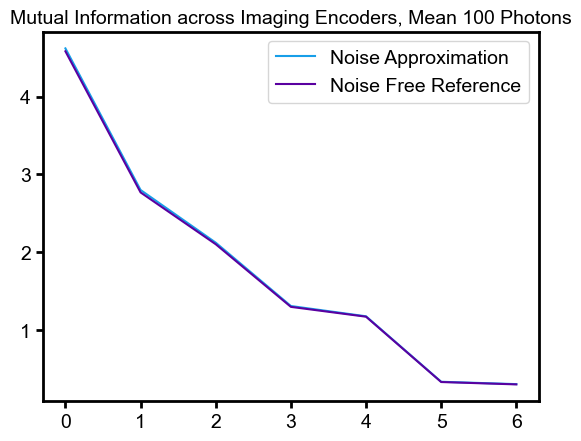

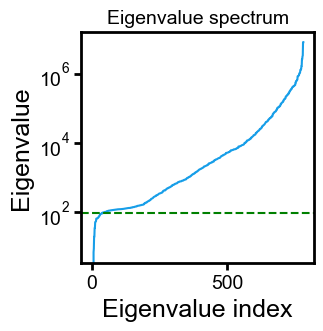

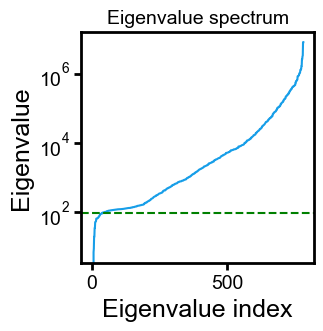

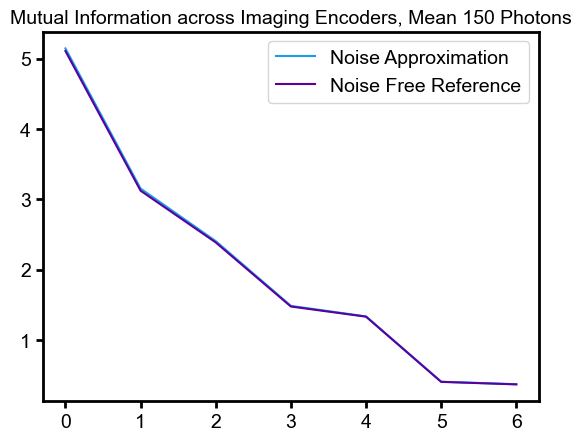

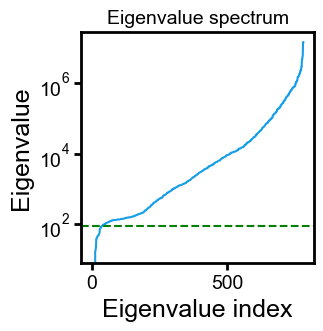

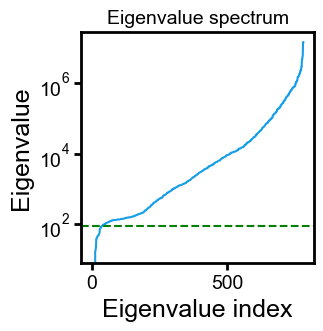

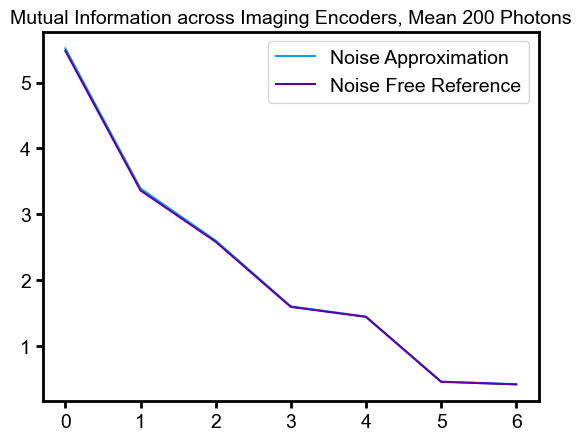

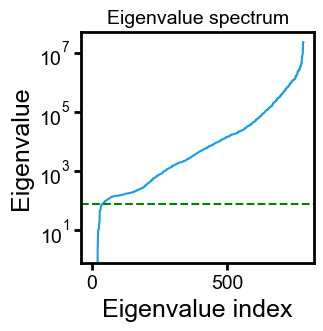

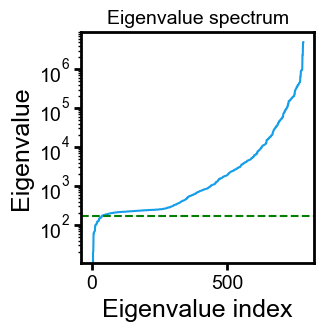

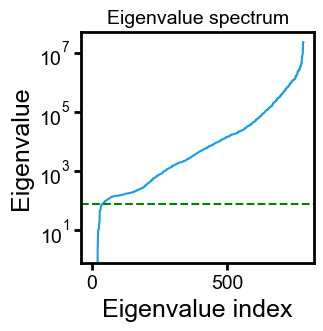

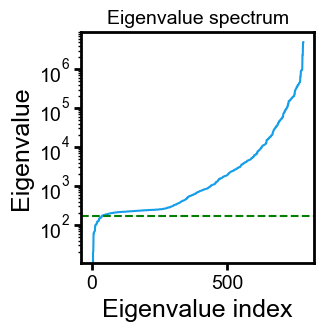

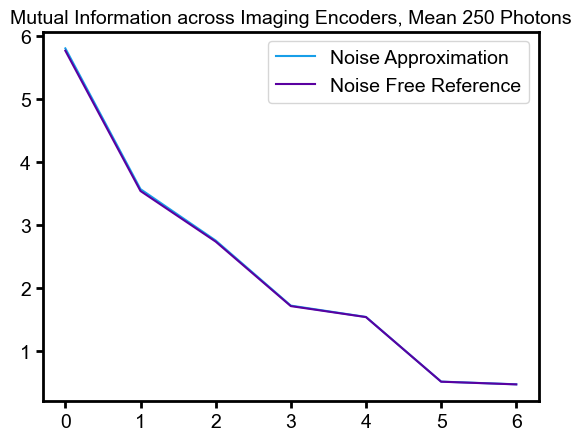

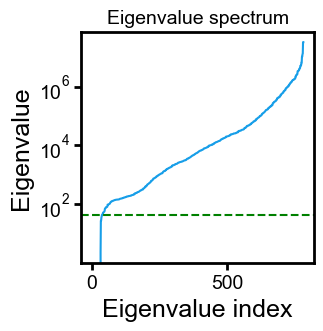

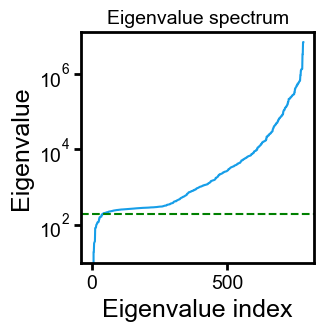

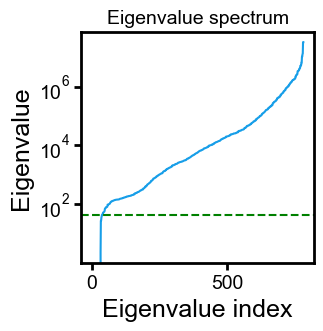

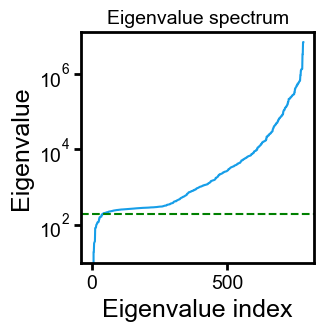

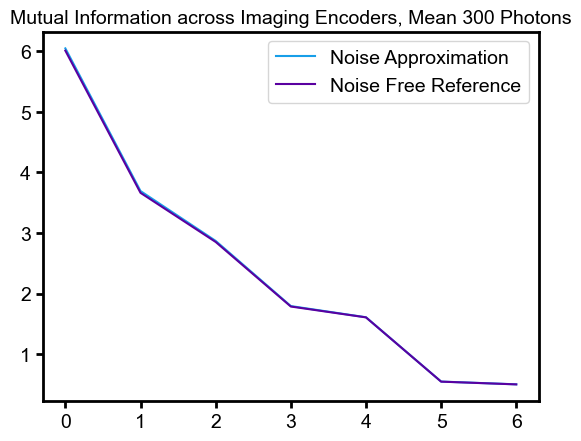

In [ ]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]
patch_size = 28
num_patches = 1000
cutoff = 5
bias = 20 # 5 photons
for mean_photon in mean_photons:
    # go through entire process
    #load mnist data
    print('Loading data and normalizing to mean_photon = ', mean_photon)
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
    data = data.astype(np.float32)
    # adjust for mean value
    for i in range(data.shape[0]):
        data[i] /= np.max(data[i]) # max normalize
        data[i] /= np.mean(data[i]) # then mean normalize
        data[i] = data[i] * mean_photon # shift to have mean pixel value of mean_photon
    labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 
    # set seed value for reproducibility and tile data using full mnist dataset
    seed_value = 1
    random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
    # make the 5 datasets 
    print('Making the convolved datasets')
    uc_data = convolved_dataset(no_psf, random_data)
    one_data = convolved_dataset(one_psf, random_data)
    two_data = convolved_dataset(two_psf, random_data)
    psf_4_data = convolved_dataset(psf_4_psf, random_data)
    diffuser_data = convolved_dataset(diffuser_psf, random_data)
    phlat_data = convolved_dataset(phlat_psf, random_data)
    rml_data = convolved_dataset(rml_psf, random_data)
    # add bias to each one rather than getting rid of negative values
    uc_data += bias 
    one_data += bias
    two_data += bias
    psf_4_data += bias
    diffuser_data += bias
    phlat_data += bias
    rml_data += bias
    # add the appropriate amount of shot noise
    print("Adding shot noise to each dataset")
    uc_data_shot = add_shot_noise_new(uc_data)
    one_data_shot = add_shot_noise_new(one_data)
    two_data_shot = add_shot_noise_new(two_data)
    psf_4_data_shot = add_shot_noise_new(psf_4_data)
    diffuser_data_shot = add_shot_noise_new(diffuser_data)
    phlat_data_shot = add_shot_noise_new(phlat_data)
    rml_data_shot = add_shot_noise_new(rml_data)
    print("Extracting patches from each dataset")
    # extract patches with no noise
    uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    # patches with noise
    uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    print("Computing Mutual Information")
    # calculate using clean images
    uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    clean_output = [uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi]
    # calculate without any clean images
    uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    not_clean_output = [uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc]
    plt.figure()
    plt.plot(not_clean_output, label='Noise Approximation')
    plt.plot(clean_output, label='Noise Free Reference')
    plt.legend()
    plt.title('Mutual Information across Imaging Encoders, Mean {} Photons'.format(mean_photon))
    mi_using_clean.append(clean_output)
    mi_without_clean.append(not_clean_output)
                    

In [ ]:
np.save('mi_estimates/mi_using_clean_1k_images_bias_20.npy', mi_using_clean)
np.save('mi_estimates/mi_without_clean_1k_images_bias_20.npy', mi_without_clean)

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images, 10 photon bias')

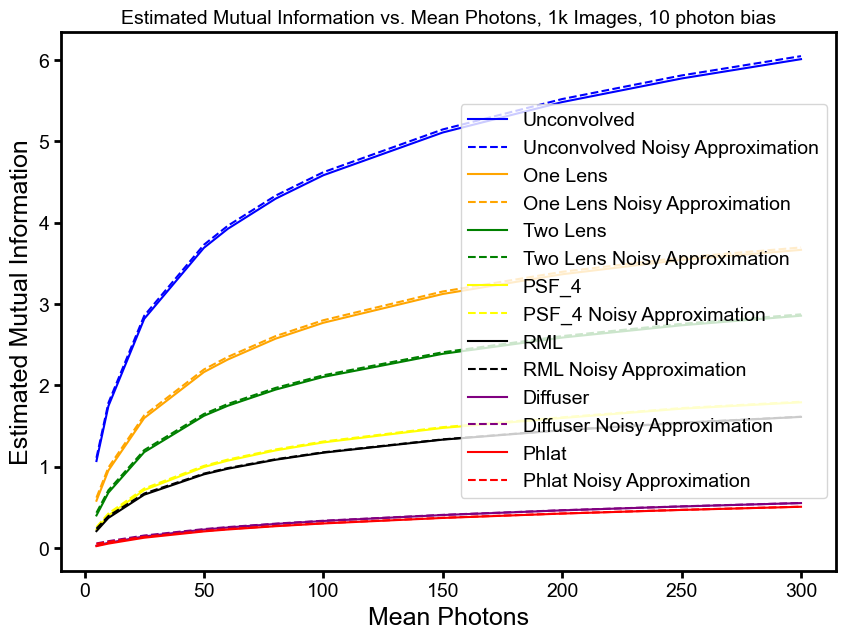

In [ ]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_1k_images_bias_20.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_1k_images_bias_20.npy')

plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color='yellow')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color='yellow', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 1k Images, 20 photon bias')

## Sweep different photon levels - use photon levels of 1, 2, 5, 10, 25, 50, 60, 80, 100 for 10k images, 20 photon bias
Keeping patch size at 28 is reasonable, now need to change photon levels.

### Load MNIST dataset and check average photon amount
Use average photons going forward. Sweep from 50 to 300 or 500 photons average.
The original data on 0-255 scale has an average pixel value of 33.39. 

In [ ]:
# og, uc, one_lens, two_lens, psf_4, rml, diffuser_phlat
mi_using_clean = []
mi_without_clean = []

In [ ]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]
patch_size = 28
num_patches = 10000
cutoff = 5
bias = 20 # 5 photons
for mean_photon in mean_photons:
    # go through entire process
    #load mnist data
    print('Loading data and normalizing to mean_photon = ', mean_photon)
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
    data = data.astype(np.float32)
    # adjust for mean value
    for i in range(data.shape[0]):
        data[i] /= np.max(data[i]) # max normalize
        data[i] /= np.mean(data[i]) # then mean normalize
        data[i] = data[i] * mean_photon # shift to have mean pixel value of mean_photon
    labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 
    # set seed value for reproducibility and tile data using full mnist dataset
    seed_value = 1
    random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
    # make the 5 datasets 
    print('Making the convolved datasets')
    uc_data = convolved_dataset(no_psf, random_data)
    one_data = convolved_dataset(one_psf, random_data)
    two_data = convolved_dataset(two_psf, random_data)
    psf_4_data = convolved_dataset(psf_4_psf, random_data)
    diffuser_data = convolved_dataset(diffuser_psf, random_data)
    phlat_data = convolved_dataset(phlat_psf, random_data)
    rml_data = convolved_dataset(rml_psf, random_data)
    # add bias to each one rather than getting rid of negative values
    uc_data += bias 
    one_data += bias
    two_data += bias
    psf_4_data += bias
    diffuser_data += bias
    phlat_data += bias
    rml_data += bias
    # add the appropriate amount of shot noise
    print("Adding shot noise to each dataset")
    uc_data_shot = add_shot_noise_new(uc_data)
    one_data_shot = add_shot_noise_new(one_data)
    two_data_shot = add_shot_noise_new(two_data)
    psf_4_data_shot = add_shot_noise_new(psf_4_data)
    diffuser_data_shot = add_shot_noise_new(diffuser_data)
    phlat_data_shot = add_shot_noise_new(phlat_data)
    rml_data_shot = add_shot_noise_new(rml_data)
    print("Extracting patches from each dataset")
    # extract patches with no noise
    uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_patch = extract_patches(one_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_patch = extract_patches(two_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)
    # patches with noise
    uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    one_data_shot_patch = extract_patches(one_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    two_data_shot_patch = extract_patches(two_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
    print("Computing Mutual Information")
    # calculate using clean images
    uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi = estimate_mutual_information(one_data_shot_patch, clean_images=one_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi = estimate_mutual_information(two_data_shot_patch, clean_images=two_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    clean_output = [uc_mi, one_mi, two_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi]
    # calculate without any clean images
    uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    one_mi_nc = estimate_mutual_information(one_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    two_mi_nc = estimate_mutual_information(two_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
    not_clean_output = [uc_mi_nc, one_mi_nc, two_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc]
    plt.figure()
    plt.plot(not_clean_output, label='Noise Approximation')
    plt.plot(clean_output, label='Noise Free Reference')
    plt.legend()
    plt.title('Mutual Information across Imaging Encoders, Mean {} Photons'.format(mean_photon))
    mi_using_clean.append(clean_output)
    mi_without_clean.append(not_clean_output)
                    

Loading data and normalizing to mean_photon =  5


Making the convolved datasets


 82%|████████▏ | 57060/70000 [00:25<00:05, 2240.72it/s]

In [ ]:
np.save('mi_estimates/mi_using_clean_10k_images_bias_20.npy', mi_using_clean)
np.save('mi_estimates/mi_without_clean_10k_images_bias_20.npy', mi_without_clean)

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images, 5 photon bias')

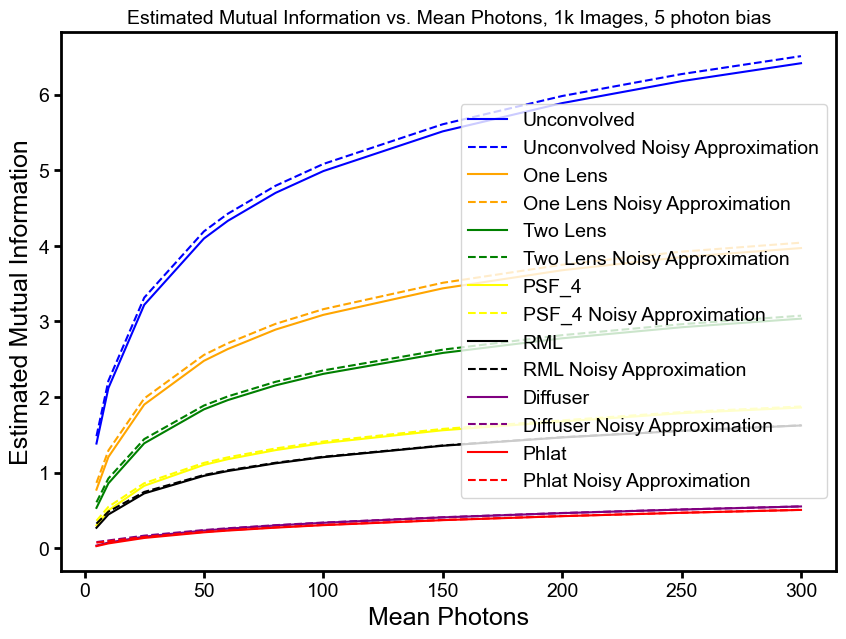

In [ ]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_10k_images_bias_20.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_10k_images_bias_20.npy')

plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color='yellow')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color='yellow', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 10k Images, 20 photon bias')

## Archive Plots

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images')

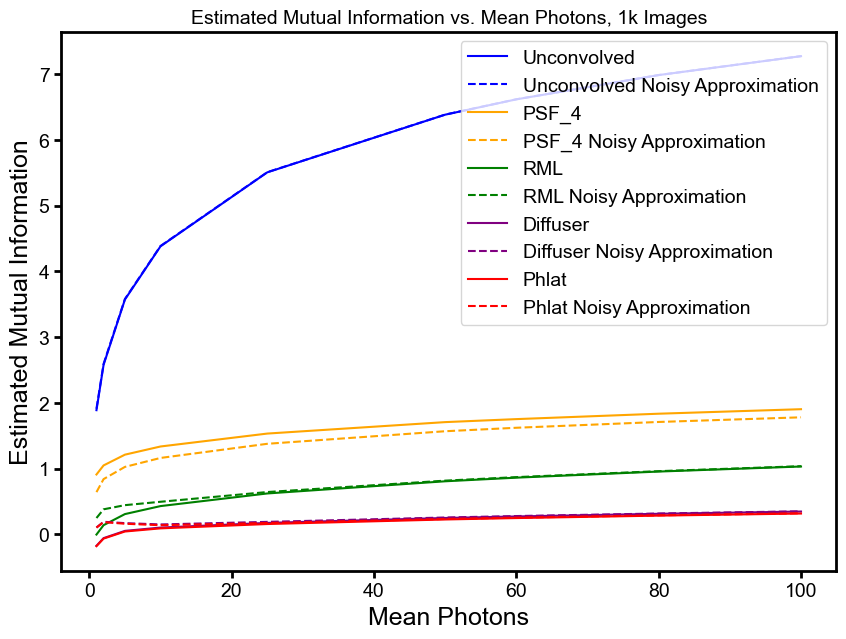

In [ ]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_1k_images.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_1k_images.npy')
plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='PSF_4', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='PSF_4 Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='RML', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='RML Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 1k Images')

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 10k Images')

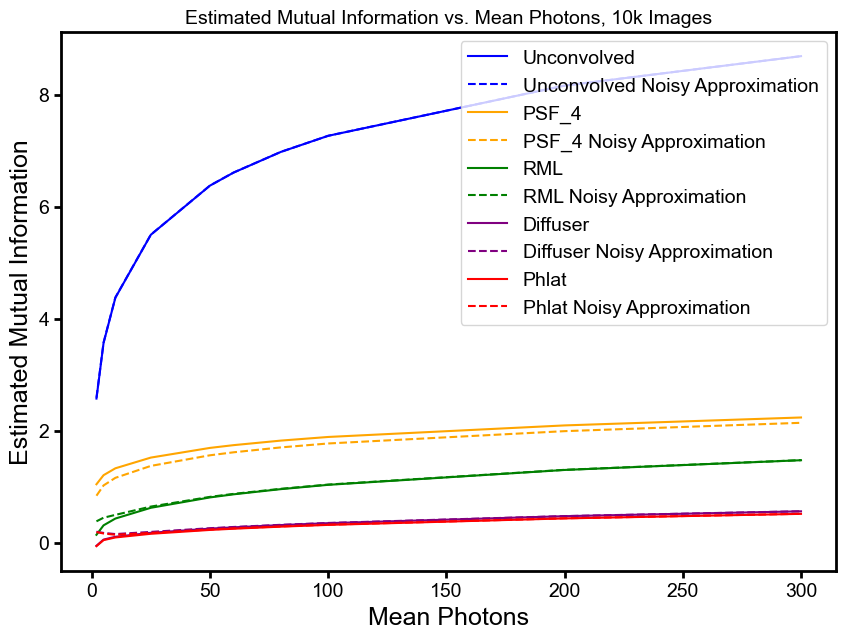

In [ ]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_10k_images.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_10k_images.npy')
plt.figure(figsize=(10, 7))
plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='PSF_4', color='orange')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='PSF_4 Noisy Approximation', color='orange', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='RML', color='green')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='RML Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='Diffuser', color='purple')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='Diffuser Noisy Approximation', color='purple', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='Phlat', color='red')
plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 10k Images')

## New Plots

In [8]:
mean_photons = [5, 10, 25, 50, 60, 80, 100, 150, 200, 250, 300]

In [13]:
from cleanplots import *
get_color_cycle()[0]

'#179EE8'

Text(0.5, 1.0, 'Estimated Mutual Information vs. Mean Photons, 1k Images, 10 photon bias')

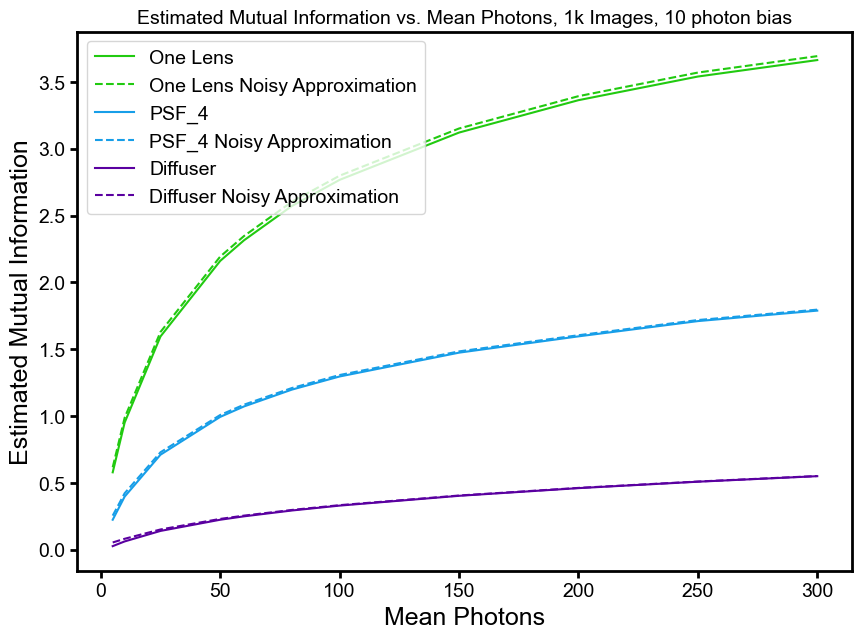

In [17]:
mi_using_clean = np.load('mi_estimates/mi_using_clean_1k_images_bias_10.npy')
mi_without_clean = np.load('mi_estimates/mi_without_clean_1k_images_bias_10.npy')

plt.figure(figsize=(10, 7))
# plt.plot(mean_photons, np.array(mi_using_clean)[:, 0], label='Unconvolved', color='blue')
# plt.plot(mean_photons, np.array(mi_without_clean)[:, 0], label='Unconvolved Noisy Approximation', color = 'blue', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 1], label='One Lens', color=get_color_cycle()[3])
plt.plot(mean_photons, np.array(mi_without_clean)[:, 1], label='One Lens Noisy Approximation', color=get_color_cycle()[3], linestyle='--')
# plt.plot(mean_photons, np.array(mi_using_clean)[:, 2], label='Two Lens', color='green')
# plt.plot(mean_photons, np.array(mi_without_clean)[:, 2], label='Two Lens Noisy Approximation', color='green', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 3], label='PSF_4', color=get_color_cycle()[0])
plt.plot(mean_photons, np.array(mi_without_clean)[:, 3], label='PSF_4 Noisy Approximation', color=get_color_cycle()[0], linestyle='--')
# plt.plot(mean_photons, np.array(mi_using_clean)[:, 4], label='RML', color='black')
# plt.plot(mean_photons, np.array(mi_without_clean)[:, 4], label='RML Noisy Approximation', color='black', linestyle='--')
plt.plot(mean_photons, np.array(mi_using_clean)[:, 5], label='Diffuser', color=get_color_cycle()[1])
plt.plot(mean_photons, np.array(mi_without_clean)[:, 5], label='Diffuser Noisy Approximation', color=get_color_cycle()[1], linestyle='--')
# plt.plot(mean_photons, np.array(mi_using_clean)[:, 6], label='Phlat', color='red')
# plt.plot(mean_photons, np.array(mi_without_clean)[:, 6], label='Phlat Noisy Approximation', color='red', linestyle='--')
plt.legend()
plt.xlabel('Mean Photons')
plt.ylabel('Estimated Mutual Information')
plt.title('Estimated Mutual Information vs. Mean Photons, 1k Images, 10 photon bias')